In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
import numpy as np
import scanpy.api as sc
from anndata import read_h5ad
from anndata import AnnData
import scipy as sp
import scipy.stats
from gprofiler import GProfiler
import pickle
from adjustText import adjust_text
from matplotlib import gridspec
# Other specific functions 
from itertools import product
from statsmodels.stats.multitest import multipletests
import util

# autoreload
%load_ext autoreload
%autoreload 2
# logging
sc.logging.print_versions()

/home/martin/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


scanpy==1.4.3 anndata==0.6.20 umap==0.3.8 numpy==1.16.4 scipy==1.2.1 pandas==0.25.0 scikit-learn==0.21.1 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


## Load data

In [2]:
data_path = '/data3/martin/tms_gene_data'
anno_data_folder = data_path + '/annotation_data'
DE_result_path = data_path + '/DE_result'
output_folder_fig = data_path + '/results/tms_gene_figure'
output_folder_tab = data_path + '/results/tms_gene_table'

In [3]:
# Load the data 
adata_combine = util.load_normalized_data(data_path)

In [4]:
temp_facs = adata_combine[adata_combine.obs['b_method']=='facs',]
temp_droplet = adata_combine[adata_combine.obs['b_method']=='droplet',]

In [5]:
# Add tissue.celltype label
temp_facs.obs['analyte'] = ['%s.%s'%(x,y) for x,y in 
                             zip(temp_facs.obs['tissue'],
                                 temp_facs.obs['cell_ontology_class'])]
temp_droplet.obs['analyte'] = ['%s.%s'%(x,y) for x,y in 
                             zip(temp_droplet.obs['tissue'],
                                 temp_droplet.obs['cell_ontology_class'])]

Trying to set attribute `.obs` of view, making a copy.
Trying to set attribute `.obs` of view, making a copy.


In [6]:
len(list(set(temp_facs.obs['cell_ontology_class'])))

121

### Load DE results, age, tissue.cell_type, some annotations

In [7]:
# Load DE result
with open(DE_result_path+'/DE_tissue_cell_FACS.pickle', 'rb') as handle:
    DE_result_MAST = pickle.load(handle)
    analysis_list = pickle.load(handle)
    analysis_info = pickle.load(handle)
with open(DE_result_path+'/DE_tissue_cell_droplet.pickle', 'rb') as handle:
    DE_result_MAST_droplet = pickle.load(handle)
    analysis_list_droplet = pickle.load(handle)
    analysis_info_droplet = pickle.load(handle)

In [8]:
# Generate analysis list with different thresholds
cell_type_list = list(set(temp_facs.obs['cell_ontology_class']))
tissue_list = list(set(temp_facs.obs['tissue']))
min_cell_number = 100
analysis_list = []
analysis_info = {}
# for cell_type in cell_type_list:
for tissue,cell_type in product(tissue_list, cell_type_list):
    analyte = '%s.%s'%(tissue,cell_type)
    ind_select = (temp_facs.obs['cell_ontology_class'] == cell_type) & \
                    (temp_facs.obs['tissue'] == tissue)
    n_young = (temp_facs.obs['age'][ind_select].isin(['1m', '3m'])).sum()
    n_old = (temp_facs.obs['age'][ind_select].isin(['18m', '21m',
                                                   '24m', '30m'])).sum()
    if (n_young>min_cell_number) & (n_old>min_cell_number) & ('nan' not in cell_type):
        print('%s, n_young=%d, n_old=%d'%(analyte, n_young, n_old))
        analysis_list.append(analyte)
analysis_list.sort()

MAT.endothelial cell, n_young=117, n_old=136
MAT.B cell, n_young=116, n_old=254
MAT.mesenchymal stem cell of adipose, n_young=601, n_old=795
MAT.macrophage, n_young=119, n_old=109
Mammary_Gland.luminal epithelial cell of mammary gland, n_young=452, n_old=148
Mammary_Gland.basal cell, n_young=1186, n_old=426
Heart.endocardial cell, n_young=164, n_old=211
Heart.valve cell, n_young=158, n_old=157
Heart.endothelial cell of coronary artery, n_young=1179, n_old=1515
Heart.atrial myocyte, n_young=159, n_old=244
Heart.monocyte, n_young=490, n_old=791
Heart.fibroblast of cardiac tissue, n_young=2118, n_old=1593
Skin.epidermal cell, n_young=260, n_old=232
Skin.basal cell of epidermis, n_young=678, n_old=994
Skin.bulge keratinocyte, n_young=1370, n_old=1234
BAT.endothelial cell, n_young=166, n_old=247
BAT.B cell, n_young=198, n_old=331
BAT.myeloid cell, n_young=168, n_old=592
Kidney.fenestrated cell, n_young=113, n_old=155
Kidney.kidney collecting duct epithelial cell, n_young=124, n_old=321
Panc

In [9]:
cell_type_list = list(set(temp_droplet.obs['cell_ontology_class']))
tissue_list = list(set(temp_droplet.obs['tissue']))
min_cell_number = 500
analysis_list_droplet = []
# for cell_type in cell_type_list:
for tissue,cell_type in product(tissue_list, cell_type_list):
    analyte = '%s.%s'%(tissue,cell_type)
    ind_select = (temp_droplet.obs['cell_ontology_class'] == cell_type) & \
                    (temp_droplet.obs['tissue'] == tissue)
    n_young = (temp_droplet.obs['age'][ind_select].isin(['1m', '3m'])).sum()
    n_old = (temp_droplet.obs['age'][ind_select].isin(['18m', '21m',
                                                   '24m', '30m'])).sum()
    if (n_young>min_cell_number) & (n_old>min_cell_number) & ('nan' not in cell_type):
        print('%s, n_young=%d, n_old=%d'%(analyte, n_young, n_old))
        analysis_list_droplet.append(analyte)
analysis_list_droplet.sort()

Spleen.B cell, n_young=5431, n_old=13845
Spleen.T cell, n_young=1653, n_old=3473
Marrow.granulocyte, n_young=1409, n_old=9647
Marrow.monocyte, n_young=778, n_old=1615
Marrow.granulocytopoietic cell, n_young=1476, n_old=6123
Thymus.thymocyte, n_young=696, n_old=1929
Mammary_Gland.B cell, n_young=630, n_old=690
Mammary_Gland.T cell, n_young=1798, n_old=1186
Mammary_Gland.stromal cell, n_young=626, n_old=1996
Limb_Muscle.endothelial cell, n_young=1599, n_old=3168
Limb_Muscle.skeletal muscle satellite cell, n_young=850, n_old=1058
Limb_Muscle.mesenchymal stem cell, n_young=3798, n_old=8781
Limb_Muscle.T cell, n_young=542, n_old=571
Limb_Muscle.macrophage, n_young=538, n_old=1766
Liver.hepatocyte, n_young=2067, n_old=510
Liver.Kupffer cell, n_young=503, n_old=1884
Bladder.bladder cell, n_young=1827, n_old=1062
Bladder.bladder urothelial cell, n_young=1352, n_old=3894
Lung.alveolar macrophage, n_young=893, n_old=705
Lung.intermediate monocyte, n_young=767, n_old=1239
Lung.capillary endotheli

In [10]:
# testing parameters
coef_threshold = 0.005
fc_threshold = 0.01

In [11]:
dic_DE_result = {'FACS':DE_result_MAST, 'droplet':DE_result_MAST_droplet}
dic_data = {'FACS':temp_facs, 'droplet':temp_droplet}

In [12]:
method_list = ['FACS', 'droplet']
dic_analysis_list = {'FACS':analysis_list, 'droplet':analysis_list_droplet}
dic_fdr_threshold = {x:0.01 for x in method_list}

In [13]:
df_cell_category = pd.read_csv(anno_data_folder + '/cell_ontology_class_functional_annotations.csv',
                               header=0, index_col=0)
df_cell_category = df_cell_category.fillna('')
# clean up
df_cell_category['analyte'] = ['%s.%s'%(x,y) for x,y in zip(df_cell_category.index,
                                                      df_cell_category['cell_ontology_class'])]
df_cell_category.index = df_cell_category['analyte']
ind_select = (df_cell_category['functional_annotations (correction by Martin)']!='')
df_cell_category.loc[ind_select, 'functional_annotations'] = \
    df_cell_category.loc[ind_select, 'functional_annotations (correction by Martin)']
df_cell_category['cell category'] = ['%s;%s'%(x,y) if y!='' else x
                                     for x,y in zip(df_cell_category['functional_annotations'],
                                                      df_cell_category['secondary_functional_annotations'])]

df_cell_category = df_cell_category[['cell category', 'turnover rate in mouse', 
                                     'turnover rate in human']]
df_cell_category = df_cell_category.loc[analysis_list]

### Summarizing number of discoveries

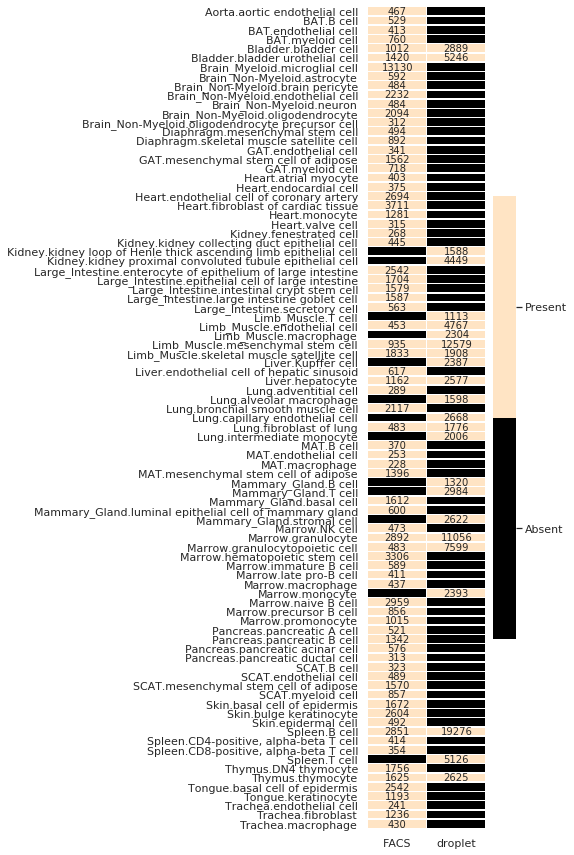

In [14]:
from matplotlib.colors import LinearSegmentedColormap
analysis_list_total = list(set(analysis_list) | set(analysis_list_droplet))
analysis_list_total.sort()
temp_df = pd.DataFrame(index=analysis_list_total)
temp_df_ct = pd.DataFrame(index=analysis_list_total)
# temp_df['FACS'] = [True if x in analysis_list else False for x in analysis_list_total]
# temp_df['droplet'] = [True if x in analysis_list_droplet else False for x in analysis_list_total]
for method in ['FACS', 'droplet']:
    temp_df[method] = [True if x in dic_analysis_list[method] else False 
                       for x in analysis_list_total]
    if method=='FACS':
        temp_df_ct[method] = [((temp_facs.obs['tissue']==x.split('.')[0]) & 
                               (temp_facs.obs['cell_ontology_class']==x.split('.')[1])).sum() 
                              for x in analysis_list_total]
    else:
        temp_df_ct[method] = [((temp_droplet.obs['tissue']==x.split('.')[0]) & 
                               (temp_droplet.obs['cell_ontology_class']==x.split('.')[1])).sum() 
                              for x in analysis_list_total]
    temp_df_ct[method] = [ '' if x*y==0 else '%d'%(x)
                          for x,y in zip(temp_df_ct[method], temp_df[method])]
# Heatmap
plt.figure(figsize = [8,12])
colors = ["black", "bisque"] 
cmap = LinearSegmentedColormap.from_list('Custom', colors, len(colors))
ax = sns.heatmap(temp_df, cmap=cmap, yticklabels=True,
                 annot=temp_df_ct, fmt="s", linewidths=.5)
# Set the colorbar labels
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([0.25,0.75])
colorbar.set_ticklabels(['Absent', 'Present'])
plt.tight_layout(rect=[0, 0, 0.95, 1])
plt.savefig(output_folder_fig + '/data_tc.pdf', transparent=True)
plt.show()

In [15]:
# Visualize the number of discoveries
plot_list = analysis_list
method = 'FACS'
temp_df = pd.DataFrame(index = plot_list)
temp_df['%s'%method] = [np.sum((dic_DE_result[method][x]['bh-p']<dic_fdr_threshold[method]) &
                        (np.absolute(dic_DE_result[method][x]['coef'])>coef_threshold))
                     for x in plot_list]
temp_df['up'] = [np.log10(np.sum((dic_DE_result[method][x]['bh-p']<dic_fdr_threshold[method]) &
                        ((dic_DE_result[method][x]['coef']>coef_threshold))))
                         for x in plot_list]
temp_df['down'] = [-np.log10(np.sum((dic_DE_result[method][x]['bh-p']<dic_fdr_threshold[method]) &
                            ((dic_DE_result[method][x]['coef']<-coef_threshold))))
                           for x in plot_list]     
temp_df['up/down'] = 10**(temp_df['up']+temp_df['down'])
temp_df['tissue'] = [x.split('.')[0] for x in temp_df.index]
temp_df['n_cell'] = [np.log10(np.sum(temp_facs.obs['analyte']==x)) for x in temp_df.index]
ind_select = temp_df['up']>np.absolute(temp_df['down'])
print('%d/%d up regulation'%(np.sum(ind_select),  temp_df.shape[0]))
temp_df.loc[ind_select]

14/76 up regulation


,FACS,up,down,up/down,tissue,n_cell
BAT.B cell,425,2.468347,-2.117271,2.244275,BAT,2.723456
Brain_Non-Myeloid.oligodendrocyte precursor cell,772,2.636488,-2.530200,1.277286,Brain_Non-Myeloid,2.494155
Large_Intestine.enterocyte of epithelium of large intestine,2185,3.152900,-2.882525,1.863696,Large_Intestine,3.405176
Large_Intestine.epithelial cell of large intestine,845,2.877371,-1.959041,8.285714,Large_Intestine,3.231470
Large_Intestine.large intestine goblet cell,1070,2.880814,-2.491362,2.451613,Large_Intestine,3.200577
Large_Intestine.secretory cell,1304,2.856729,-2.767156,1.229060,Large_Intestine,2.750508
Liver.endothelial cell of hepatic sinusoid,534,2.463893,-2.385606,1.197531,Liver,2.790285
MAT.B cell,99,1.875061,-1.380211,3.125000,MAT,2.568202
MAT.endothelial cell,119,1.875061,-1.643453,1.704545,MAT,2.403121
MAT.macrophage,91,1.892095,-1.113943,6.000000,MAT,2.357935


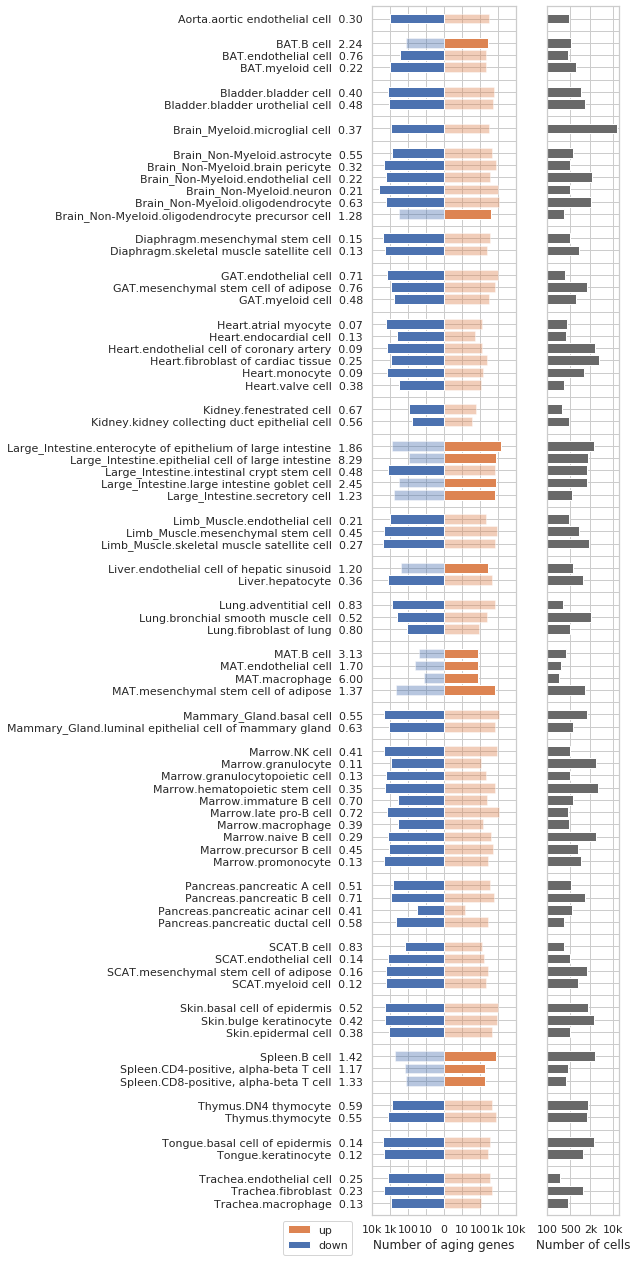

In [16]:
tissue_list = list(set(temp_facs.obs['tissue']))
tissue_list.sort()
df_place_holder = pd.DataFrame(columns = temp_df.columns, index=[''], data=np.nan)

temp_list = tissue_list.copy()
temp_plot_df = pd.DataFrame(columns = temp_df.columns)
for i_tissue,tissue in enumerate(temp_list):
    temp_plot_df = temp_plot_df.append(temp_df.loc[temp_df['tissue']==tissue])
    if i_tissue < len(temp_list)-1:
        temp_plot_df = temp_plot_df.append(df_place_holder)
temp_plot_df = temp_plot_df.iloc[::-1]

# make figure 
plt.figure(figsize=[8.8,0.18*temp_plot_df.shape[0]])
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1]) 

plt.subplot(gs[0])
ind_select = temp_plot_df['up']>np.absolute(temp_plot_df['down'])
plt.barh(np.arange(temp_plot_df.shape[0])[ind_select],
         temp_plot_df['up'][ind_select], label='up', color='C1')
plt.barh(np.arange(temp_plot_df.shape[0])[~ind_select],
         temp_plot_df['up'][~ind_select], alpha=0.4, color='C1')
plt.barh(np.arange(temp_plot_df.shape[0])[~ind_select],
         temp_plot_df['down'][~ind_select], label='down', color='C0')
plt.barh(np.arange(temp_plot_df.shape[0])[ind_select],
         temp_plot_df['down'][ind_select], alpha=0.4, color='C0')
x_tick = list(-np.log10([10000, 1000, 100, 10])) + [0] + \
                list(np.log10([10, 100, 1000, 10000])) 
plt.xticks(x_tick, ['10k', '1k', '100', '10', '0', '10', '100', '1k', '10k'])
temp_y_tick = ['%s  %0.2f'%(x,y) if len(x)>0 else x 
               for x,y in zip(temp_plot_df.index, temp_plot_df['up/down']) ]
plt.yticks(np.arange(temp_plot_df.shape[0]), temp_y_tick)
plt.ylim([-1, temp_plot_df.shape[0]])
plt.legend(bbox_to_anchor=(-0.1, 0))
plt.xlabel('Number of aging genes')

plt.subplot(gs[1])
plt.barh(np.arange(temp_plot_df.shape[0]), temp_plot_df['n_cell'],
         color='dimgray')
x_tick = np.log10([100, 500, 2000, 10000])
plt.xticks(x_tick, ['100', '500', '2k', '10k'])
plt.yticks(np.arange(temp_plot_df.shape[0]), ['']*temp_plot_df.shape[0])
plt.xlim([2, np.log10(15000)])
plt.ylim([-1, temp_plot_df.shape[0]])
plt.xlabel('Number of cells')
plt.tight_layout()
plt.savefig(output_folder_fig + '/tc_discovery.pdf',
            transparent=True)
plt.show()

### Meta information

In [17]:
df_analysis = pd.DataFrame(index = analysis_list, 
                           data = [ x.split('.') for x in analysis_list],
                           columns = ['tissue', 'cell_type'])
temp_df = temp_facs.obs[['age', 'cell_ontology_class', 'tissue', 'n_genes']]
temp_df['young'] = list(temp_df['age'].isin(['1m', '3m']))
temp_df = temp_df.groupby(['tissue', 'cell_ontology_class', 'young'])\
            .n_genes.agg([len, 'mean'])
temp_df.reset_index(inplace=True)
temp_df.index = [x+'.'+y for x,y in zip(temp_df['tissue'], temp_df['cell_ontology_class'])]
temp_df.columns = ['tissue', 'cell_type', 'young', 'n_cell', 'n_gene_mean']
ind_select = temp_df['young']
temp_df_young = temp_df.loc[ind_select, ['n_cell', 'n_gene_mean']]
temp_df_young.columns = ['n_cell_young', 'n_gene_mean_young']
temp_df_old = temp_df.loc[~ind_select, ['n_cell', 'n_gene_mean']]
temp_df_old.columns = ['n_cell_old', 'n_gene_mean_old']
df_analysis = df_analysis.join(temp_df_young)
df_analysis = df_analysis.join(temp_df_old)
# # of rejction 

temp_df = pd.DataFrame(index = analysis_list, 
                       data = [ (np.sum((DE_result_MAST[x]['bh-p']<0.01) & 
                                        (np.absolute(DE_result_MAST[x]['coef'])>coef_threshold))) 
                               for x in analysis_list],
                       columns = ['n_rej'])
df_analysis = df_analysis.join(temp_df)

/home/martin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [18]:
df_analysis_droplet = pd.DataFrame(index = analysis_list_droplet, 
                           data = [ x.split('.') for x in analysis_list_droplet],
                           columns = ['tissue', 'cell_type'])
temp_df = temp_droplet.obs[['age', 'cell_ontology_class', 'tissue', 'n_genes']]
temp_df['young'] = list(temp_df['age'].isin(['1m', '3m']))
temp_df = temp_df.groupby(['tissue', 'cell_ontology_class', 'young'])\
            .n_genes.agg([len, 'mean'])
temp_df.reset_index(inplace=True)
temp_df.index = [x+'.'+y for x,y in zip(temp_df['tissue'], temp_df['cell_ontology_class'])]
temp_df.columns = ['tissue', 'cell_type', 'young', 'n_cell', 'n_gene_mean']
ind_select = temp_df['young']
temp_df_young = temp_df.loc[ind_select, ['n_cell', 'n_gene_mean']]
temp_df_young.columns = ['n_cell_young', 'n_gene_mean_young']
temp_df_old = temp_df.loc[~ind_select, ['n_cell', 'n_gene_mean']]
temp_df_old.columns = ['n_cell_old', 'n_gene_mean_old']
df_analysis_droplet = df_analysis_droplet.join(temp_df_young)
df_analysis_droplet = df_analysis_droplet.join(temp_df_old)
# # of rejction 

temp_df = pd.DataFrame(index = analysis_list_droplet, 
                       data = [ (np.sum((DE_result_MAST_droplet[x]['bh-p']<0.01) & 
                                        (np.absolute(DE_result_MAST_droplet[x]['coef'])>coef_threshold))) 
                               for x in analysis_list_droplet],
                       columns = ['n_rej'])
df_analysis_droplet = df_analysis_droplet.join(temp_df)

/home/martin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


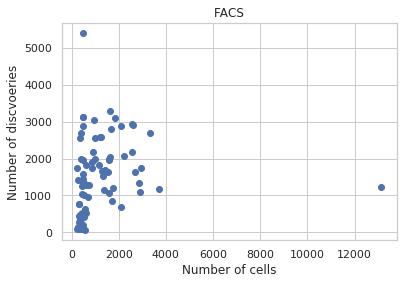

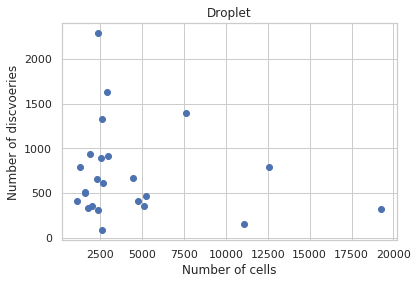

In [19]:
plt.figure()
plt.scatter(df_analysis['n_cell_old'] + df_analysis['n_cell_young'],
            df_analysis['n_rej'])
plt.xlabel('Number of cells')
plt.ylabel('Number of discvoeries')
plt.title('FACS')
plt.show()
plt.figure()
plt.scatter(df_analysis_droplet['n_cell_old'] + df_analysis_droplet['n_cell_young'],
            df_analysis_droplet['n_rej'])
plt.xlabel('Number of cells')
plt.ylabel('Number of discvoeries')
plt.title('Droplet')
plt.show()

### Global and tissue-cell type specific aging genes

In [20]:
gene_name_list = list(temp_facs.var_names)
df_raw_p_MAST = pd.DataFrame(index = gene_name_list)
df_bh_p_MAST = pd.DataFrame(index = gene_name_list)
df_fc_MAST = pd.DataFrame(index = gene_name_list)
for analyte in analysis_list:
    df_raw_p_MAST[analyte] = DE_result_MAST[analyte]['raw-p']
    df_bh_p_MAST[analyte] = DE_result_MAST[analyte]['bh-p']
    df_fc_MAST[analyte] = DE_result_MAST[analyte]['coef']
df_raw_p_MAST_droplet = pd.DataFrame(index = gene_name_list)
df_bh_p_MAST_droplet = pd.DataFrame(index = gene_name_list)
df_fc_MAST_droplet = pd.DataFrame(index = gene_name_list)
for analyte in analysis_list_droplet:
    df_raw_p_MAST_droplet[analyte] = DE_result_MAST_droplet[analyte]['raw-p']
    df_bh_p_MAST_droplet[analyte] = DE_result_MAST_droplet[analyte]['bh-p']
    df_fc_MAST_droplet[analyte] = DE_result_MAST_droplet[analyte]['coef']

In [21]:
# Store the testing result to excel 
df_raw_p_MAST.to_csv(output_folder_tab + '/DGE_result.tissue_cell.FACS.raw_p.csv')
df_bh_p_MAST.to_csv(output_folder_tab + '/DGE_result.tissue_cell.FACS.bh_p.csv')
df_fc_MAST.to_csv(output_folder_tab + '/DGE_result.tissue_cell.FACS.age_coef.csv')
# Store the testing result to excel 
df_raw_p_MAST_droplet.to_csv(output_folder_tab + '/DGE_result.tissue_cell.droplet.raw_p.csv')
df_bh_p_MAST_droplet.to_csv(output_folder_tab + '/DGE_result.tissue_cell.droplet.bh_p.csv')
df_bh_p_MAST_droplet.to_csv(output_folder_tab + '/DGE_result.tissue_cell.droplet.age_coef.csv')

In [22]:
df_global_aging_gene = pd.DataFrame(index = gene_name_list)
df_global_aging_gene['Prop. of Sig.'] = ((df_bh_p_MAST<0.01) & 
                                         (np.absolute(df_fc_MAST)>coef_threshold)).mean(axis=1)
df_global_aging_gene['Prop. of +'] = (df_fc_MAST>coef_threshold).sum(axis=1) /\
                                        ((df_fc_MAST>coef_threshold) | \
                                         (df_fc_MAST<-coef_threshold)).sum(axis=1) 
df_global_aging_gene['Median fc'] = df_fc_MAST.median(axis=1)
df_global_aging_gene['Median bh-p'] = df_bh_p_MAST.median(axis=1)
# result for each tissue.celltype
for analyte in analysis_list:
    temp_df_bh_p_MAST = df_bh_p_MAST[[analyte]]
    temp_df_fc_MAST = df_fc_MAST[[analyte]]
    df_global_aging_gene['%s.Sig.'%(analyte)] = \
        1 * ((temp_df_bh_p_MAST<0.01) & (np.absolute(temp_df_fc_MAST)> coef_threshold))
    df_global_aging_gene['%s.Direction'%analyte] = \
        ((temp_df_fc_MAST > coef_threshold)*1 - (temp_df_fc_MAST < - coef_threshold)*1)
# Droplet
df_global_aging_gene_droplet = pd.DataFrame(index = gene_name_list)
df_global_aging_gene_droplet['Prop. of Sig.'] = ((df_bh_p_MAST_droplet<0.01) & 
                                         (np.absolute(df_fc_MAST_droplet)>coef_threshold)).mean(axis=1)
df_global_aging_gene_droplet['Prop. of +'] = (df_fc_MAST_droplet>coef_threshold).sum(axis=1) /\
                                        ((df_fc_MAST_droplet>coef_threshold) | (df_fc_MAST_droplet<-coef_threshold)).sum(axis=1)
df_global_aging_gene_droplet['Median bh-p'] = df_bh_p_MAST_droplet.median(axis=1)

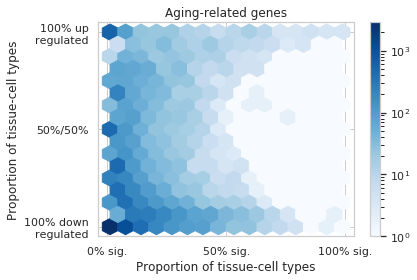

In [23]:
# for method in method_list:
ind_global = df_global_aging_gene['Prop. of Sig.']>0
temp_df = df_global_aging_gene.loc[ind_global]
plt.figure(figsize=[6,4])
plt.hexbin(temp_df['Prop. of Sig.'], temp_df['Prop. of +'], gridsize=15,
           cmap = 'Blues', bins='log')
# plt.ylabel('Proportion of tissue-cell types \nwhere the gene is up-regulated')
plt.ylabel('Proportion of tissue-cell types')
# plt.xlabel('Proportion of tissue-cell types \nwhere the gene has a significant aging effect')
plt.xlabel('Proportion of tissue-cell types')
plt.colorbar()
plt.xticks([0, 0.5, 1], ['0% sig.', '50% sig.', '100% sig.'])
plt.yticks([0, 0.5, 1], ['100% down\nregulated', '50%/50%', '100% up\nregulated'])
plt.title('Aging-related genes')
plt.tight_layout()
plt.savefig(output_folder_fig + '/tc_global_aging_scatter.pdf',
            transparent=True)
plt.show()

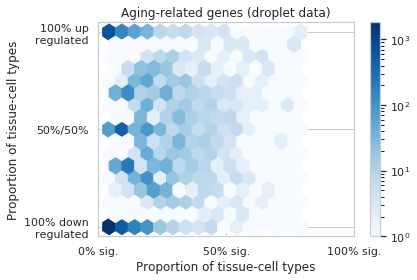

In [24]:
# for method in method_list:
ind_global = df_global_aging_gene_droplet['Prop. of Sig.']>0
temp_df = df_global_aging_gene_droplet.loc[ind_global]
plt.figure(figsize=[6,4])
plt.hexbin(temp_df['Prop. of Sig.'], temp_df['Prop. of +'], gridsize=15,
           cmap = 'Blues', bins='log')
# plt.ylabel('Proportion of tissue-cell types \nwhere the gene is up-regulated')
plt.ylabel('Proportion of tissue-cell types')
# plt.xlabel('Proportion of tissue-cell types \nwhere the gene has a significant aging effect')
plt.xlabel('Proportion of tissue-cell types')
plt.colorbar()
plt.xticks([0, 0.5, 1], ['0% sig.', '50% sig.', '100% sig.'])
plt.yticks([0, 0.5, 1], ['100% down\nregulated', '50%/50%', '100% up\nregulated'])
plt.title('Aging-related genes (droplet data)')
plt.tight_layout()
plt.savefig(output_folder_fig + '/tc_global_aging_scatter_droplet.pdf',
            transparent=True)
plt.show()

In [25]:
# Write the global aging genes 
gene_name_list = np.array(df_global_aging_gene.index)
dic_global_aging_gene = {}
# ind_global = df_global_aging_gene['Prop. of Sig.']>0.75
ind_global = df_global_aging_gene['Prop. of Sig.']>0.5
dic_global_aging_gene['all'] = (gene_name_list[ind_global]).tolist()
ind_select = ind_global & (df_global_aging_gene['Prop. of +']>0.8)
dic_global_aging_gene['up'] = gene_name_list[ind_select].tolist()
ind_select = ind_global & (df_global_aging_gene['Prop. of +']<0.2)
dic_global_aging_gene['down'] = gene_name_list[ind_select].tolist()
dic_global_aging_gene['other'] = list(set(gene_name_list[ind_global]) 
                                      - set(dic_global_aging_gene['up'])
                                      - set(dic_global_aging_gene['down']))
print('FACS, Total:%d, Up:%d, Down:%d, Other:%d'%(len(dic_global_aging_gene['all']),
                                            len(dic_global_aging_gene['up']), 
                                            len(dic_global_aging_gene['down']), 
                                            len(dic_global_aging_gene['other'])))
# droplet 
dic_global_aging_gene_droplet = {}
ind_global = df_global_aging_gene_droplet['Prop. of Sig.']>0.6
dic_global_aging_gene_droplet['all'] = (gene_name_list[ind_global]).tolist()
ind_select = ind_global & (df_global_aging_gene_droplet['Prop. of +']>0.8)
dic_global_aging_gene_droplet['up'] = gene_name_list[ind_select].tolist()
ind_select = ind_global & (df_global_aging_gene_droplet['Prop. of +']<0.2)
dic_global_aging_gene_droplet['down'] = gene_name_list[ind_select].tolist()
dic_global_aging_gene_droplet['other'] = list(set(gene_name_list[ind_global]) 
                                      - set(dic_global_aging_gene_droplet['up'])
                                      - set(dic_global_aging_gene_droplet['down']))
print('Droplet, Total:%d, Up:%d, Down:%d, Other:%d'%(len(dic_global_aging_gene_droplet['all']),
                                            len(dic_global_aging_gene_droplet['up']), 
                                            len(dic_global_aging_gene_droplet['down']), 
                                            len(dic_global_aging_gene_droplet['other'])))

FACS, Total:292, Up:93, Down:169, Other:30
Droplet, Total:16, Up:8, Down:2, Other:6


In [26]:
# Record all global aging genes
temp_df = df_global_aging_gene.copy()
temp_df = temp_df.loc[temp_df['Prop. of Sig.']>0.5]
temp_df = temp_df.sort_values(by='Prop. of Sig.', ascending=False)
temp_df = temp_df.iloc[:, 0:4]
temp_df['rank'] = np.arange(temp_df.shape[0])+1
temp_df.to_csv(output_folder_tab+'/tc.global_aging.csv')
temp_df.to_excel(output_folder_tab+'/tc.global_aging.xls')

### Tissue-cell type specific aging genes


In [27]:
category_list = ['immune', 'stem cell/progenitor', 'stromal',
                 'endothelial', 'epithelial', 'parenchymal',]
df_tc_specificity = pd.DataFrame(index=df_global_aging_gene.index)
# get data 
temp_df = df_global_aging_gene.copy()
temp_df.columns = [x.replace('.Sig.', '') for x in temp_df.columns]
for cate in category_list:
    ind_select =  [cate in x for x in df_cell_category['cell category']]
    df_tc_specificity['%s.n_celltype'%cate] = np.sum(ind_select)
    cell_type_select = df_cell_category.index[ind_select]
    df_tc_specificity['%s.n_sig'%cate] = temp_df.loc[:,cell_type_select].sum(axis=1)
    # fc
    df_tc_specificity['%s.fc'%cate] = df_fc_MAST[cell_type_select].median(axis=1)
    # add place holders
    df_tc_specificity['%s.raw_p'%cate] = 1
    df_tc_specificity['%s.bh_p'%cate] = 1

In [28]:
# Test fror tissue-cell type specificity 
for cate in category_list:
    other_cate_list = category_list.copy()
    other_cate_list.remove(cate)
    print(cate, other_cate_list)    
    ind_select = (df_tc_specificity['%s.n_sig'%cate]>0)
    for gene_name in df_tc_specificity.index[ind_select]:
        rej_cate = df_tc_specificity.loc[gene_name, '%s.n_sig'%cate]
        non_rej_cate = df_tc_specificity.loc[gene_name, '%s.n_celltype'%cate] - rej_cate
        
        temp_list = ['%s.n_sig'%x for x in other_cate_list]
        rej_other = np.sum(df_tc_specificity.loc[gene_name, temp_list])
        
        temp_list = ['%s.n_celltype'%x for x in other_cate_list]
        non_rej_other = np.sum(df_tc_specificity.loc[gene_name, temp_list]) - rej_other
        
        test_table = [[rej_cate, rej_other],
                      [non_rej_cate, non_rej_other]]
        
        _,p_val = sp.stats.fisher_exact(test_table, alternative='greater')
        df_tc_specificity.loc[gene_name, '%s.raw_p'%cate] = p_val
    # Add bh_p
    res_bh = multipletests(df_tc_specificity['%s.raw_p'%cate],
                           alpha=0.2, method='fdr_bh')
    df_tc_specificity['%s.bh_p'%cate] = res_bh[1]
#     break

immune ['stem cell/progenitor', 'stromal', 'endothelial', 'epithelial', 'parenchymal']
stem cell/progenitor ['immune', 'stromal', 'endothelial', 'epithelial', 'parenchymal']
stromal ['immune', 'stem cell/progenitor', 'endothelial', 'epithelial', 'parenchymal']
endothelial ['immune', 'stem cell/progenitor', 'stromal', 'epithelial', 'parenchymal']
epithelial ['immune', 'stem cell/progenitor', 'stromal', 'endothelial', 'parenchymal']
parenchymal ['immune', 'stem cell/progenitor', 'stromal', 'endothelial', 'epithelial']


In [29]:
# select tissue-cell type specific genes 
dic_tc_specific_gene = {}
ind_tc = ((temp_df.mean(axis=1))<0.1) & ((temp_df.mean(axis=1))>0)
for cate in category_list:
    ind_select = df_tc_specificity['%s.bh_p'%cate]<0.25
    dic_tc_specific_gene[cate] = list(df_tc_specificity.index[ind_select])
    print(cate, np.sum(ind_select))

immune 204
stem cell/progenitor 197
stromal 1
endothelial 104
epithelial 0
parenchymal 0


/home/martin/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1404: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


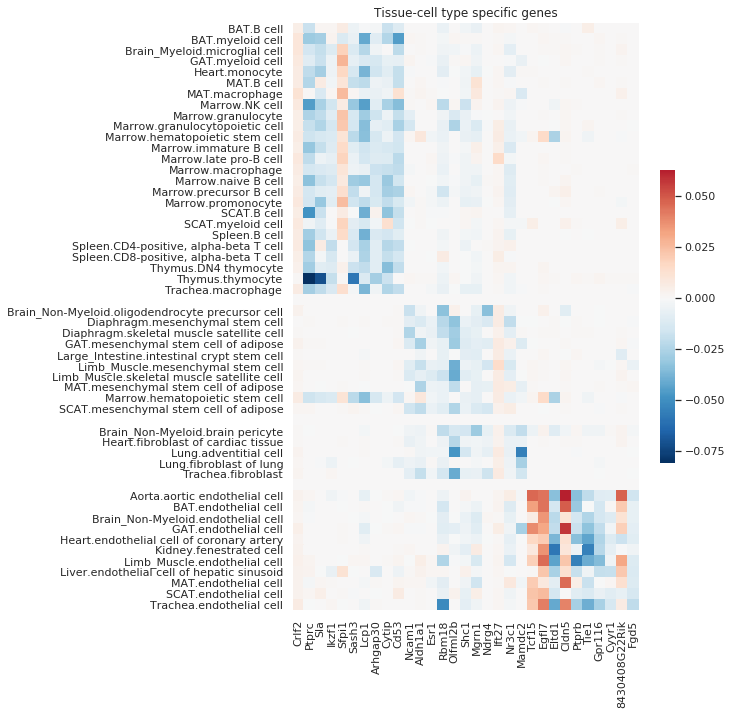

In [30]:
# visualize top genes 
temp_gene_list = []
for cate in category_list:
    temp_df = df_tc_specificity.copy()
    temp_df = temp_df.sort_values(by='%s.bh_p'%cate)
    temp_df = temp_df.iloc[0:10]
    temp_df = temp_df.loc[temp_df['%s.bh_p'%cate]<0.25]
    temp_gene_list += list(temp_df.index)
# reoroder analysis_list 
temp_category_list = ['immune', 'stem cell/progenitor', 'stromal', 'endothelial']

analysis_list_reorder = []
for cate in temp_category_list:
    ind_select =  [cate in x for x in df_cell_category['cell category']]
    temp_list = list(df_cell_category.index[ind_select])
    for analyte in temp_list:
        if analyte in analysis_list_reorder:
            temp_list.remove(analyte)
    temp_list.sort()
    analysis_list_reorder += temp_list
    if cate!=temp_category_list[-1]:
        analysis_list_reorder += ['']
gene_list_select = temp_gene_list
# visualization
temp_df = df_fc_MAST.loc[gene_list_select, analysis_list_reorder]
temp_df = temp_df.fillna(value=0)
temp_df = temp_df.T
# visualization: overview
plt.figure(figsize = [0.25*temp_df.shape[1], 0.2*temp_df.shape[0]])
sns.heatmap(temp_df, xticklabels=True, yticklabels=True,
            cmap = 'RdBu_r', center=0, cbar_kws={"shrink": 0.5})
plt.title('Tissue-cell type specific genes')
plt.savefig(output_folder_fig + '/tc_specific_heatmap.pdf',
            transparent=True, bbox_inches='tight')
plt.show()

In [31]:
# Save for IPA ``
for cate in category_list:
    temp_gene_list = dic_tc_specific_gene[cate]
    temp_df = df_tc_specificity.loc[temp_gene_list, ['%s.raw_p'%cate, '%s.bh_p'%cate,
                                                     '%s.fc'%cate]]
    temp_df = temp_df.sort_values(by='%s.bh_p'%cate)
    if temp_df.shape[0]>5:
        temp_df.to_excel(output_folder_tab+'/tc.%s.aging.xls'%cate[0:4])
#     break

/home/martin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


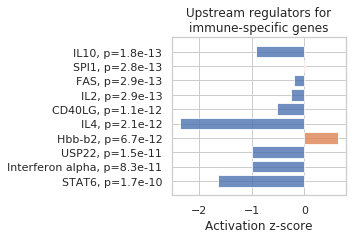

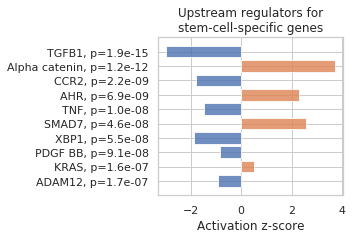

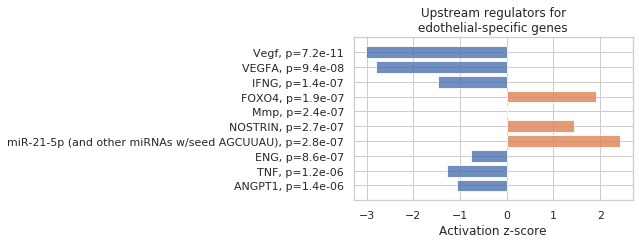

In [92]:
# Visualize the upstream regulator
for cate in ['immu', 'stem', 'endo']:
    temp_df = pd.read_excel(output_folder_tab + '/tc_%s_aging_upstream_regulators.xls'%cate,
                            header=1)
    temp_df.index = temp_df['Upstream Regulator']
    temp_df = temp_df.iloc[0:10]
    temp_df = temp_df.iloc[::-1]
    # figure
    plt.figure(figsize=[5,3])
    ind_select = temp_df['Activation z-score']>0
    plt.barh(np.arange(temp_df.shape[0])[ind_select], 
             temp_df.loc[ind_select, 'Activation z-score'],
             color = 'C1', alpha=0.8)
    ind_select = temp_df['Activation z-score']<=0
    plt.barh(np.arange(temp_df.shape[0])[ind_select], 
             temp_df.loc[ind_select, 'Activation z-score'],
             color = 'C0', alpha=0.8)
    y_tick_list = ['%s, p=%0.1e'%(x,y) for x,y in 
                   zip(temp_df.index, temp_df['p-value of overlap'])]
    plt.yticks(np.arange(temp_df.shape[0]), y_tick_list)
    plt.ylim([-1, temp_df.shape[0]])
    plt.xlabel('Activation z-score')
    plt.tight_layout()
    if cate=='immu':
        plt.title('Upstream regulators for\nimmune-specific genes')
    elif cate=='stem':
        plt.title('Upstream regulators for\nstem-cell-specific genes')
    else:
        plt.title('Upstream regulators for\nedothelial-specific genes')
    plt.savefig(output_folder_fig + '/tc_%s_up_regulator.pdf'%cate,
                transparent=True,  bbox_inches='tight')
#     break

### Heatmap of some interesting genes

In [32]:
anno_data_folder

'/data3/martin/tms_gene_data/annotation_data'

In [33]:
dic_interesting_gene_list = {}

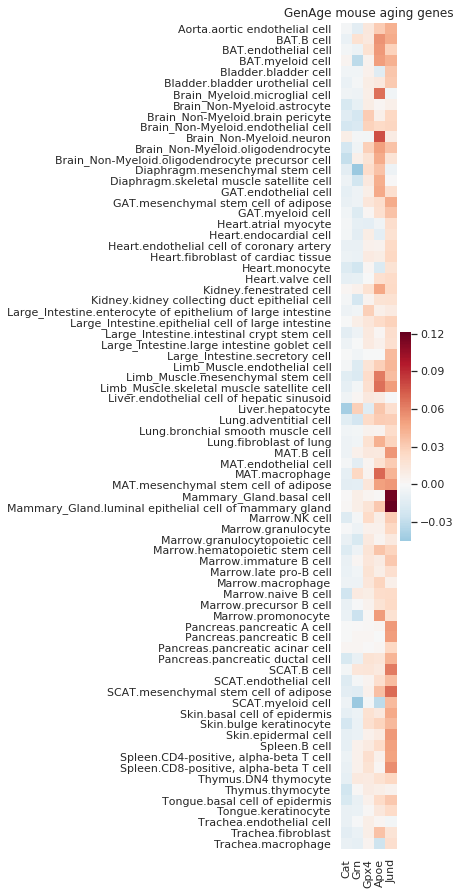

In [34]:
# AgeGen genes
df_agegen = pd.read_csv(anno_data_folder + '/GenAge/genage_models.csv')
df_agegen = df_agegen.loc[df_agegen['organism'] == 'Mus musculus']
temp_gene_list = set(df_agegen['symbol']) & set(df_global_aging_gene.index)
dic_interesting_gene_list['AgeGen'] = temp_gene_list.copy()
temp_df = df_global_aging_gene.loc[temp_gene_list]
gene_list_select = temp_df[temp_df['Prop. of Sig.']>0.5].index
# visualization
temp_df = df_fc_MAST.loc[gene_list_select]
temp_df = temp_df.fillna(value=0)
ind_sort = list(np.argsort(temp_df.median(axis=1)))
temp_df = temp_df.iloc[ind_sort]
temp_df = temp_df.T
# visualization: overview
plt.figure(figsize = [0.25*temp_df.shape[1], 0.2*temp_df.shape[0]])
sns.heatmap(temp_df, xticklabels=True, yticklabels=True,
            cmap = 'RdBu_r', center=0, cbar_kws={"shrink": 0.5})
plt.title('GenAge mouse aging genes')
plt.savefig(output_folder_fig + '/tc_GenAge_heatmap.pdf',
            transparent=True, bbox_inches='tight')
plt.show()

Index(['App', 'Ctnnb1', 'Mapk1', 'Rac1', 'Arf1', 'Junb', 'Jund'], dtype='object')


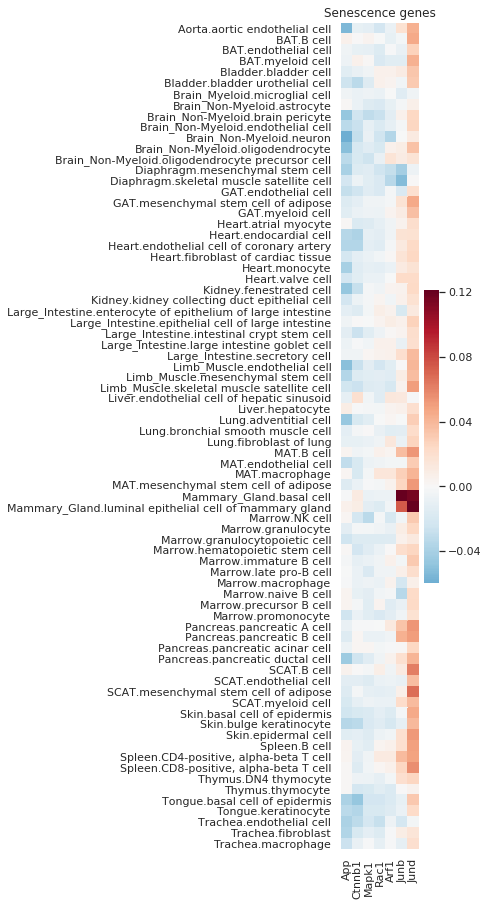

In [35]:
# senescence gene
gene_file = anno_data_folder + '/senescence_227.txt'
temp_gene_list = []
with open(gene_file) as f:
    for line in f:
        temp_gene_list.append(line.strip())
temp_gene_list = set(temp_gene_list) & set(df_global_aging_gene.index)
dic_interesting_gene_list['Senescence'] = temp_gene_list.copy()
temp_df = df_global_aging_gene.loc[temp_gene_list]
gene_list_select = temp_df[temp_df['Prop. of Sig.']>0.5].index
# visualization
temp_df = df_fc_MAST.loc[gene_list_select]
temp_df = temp_df.fillna(value=0)
ind_sort = list(np.argsort(temp_df.median(axis=1)))
temp_df = temp_df.iloc[ind_sort]
temp_df = temp_df.T
print(temp_df.columns)
# visualization: overview
plt.figure(figsize = [0.25*temp_df.shape[1], 0.2*temp_df.shape[0]])
sns.heatmap(temp_df, xticklabels=True, yticklabels=True,
            cmap = 'RdBu_r', center=0, cbar_kws={"shrink": 0.5})
plt.title('Senescence genes')
plt.savefig(output_folder_fig + '/tc_senescence_heatmap.pdf',
            transparent=True, bbox_inches='tight')
plt.show()

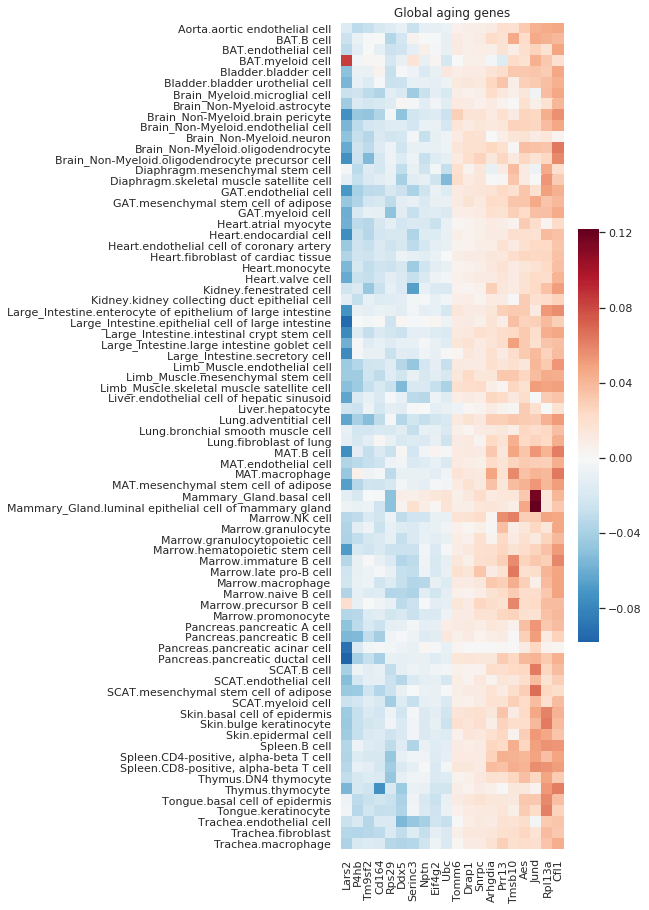

In [36]:
# Visualize global aging genes
gene_name_list = np.array(df_global_aging_gene.index)
# 10 up-regulated genes 
ind_select = (df_global_aging_gene['Prop. of Sig.']>0.5) & \
                    (df_global_aging_gene['Prop. of +']>0.8)
temp_df = df_global_aging_gene.loc[ind_select]
temp_df = temp_df.sort_values(by = 'Prop. of Sig.', ascending=False)
gene_list_select = list(temp_df.index[0:10])
# 10 down-regulated genes 
ind_select = (df_global_aging_gene['Prop. of Sig.']>0.5) & \
                    (df_global_aging_gene['Prop. of +']<0.2)
temp_df = df_global_aging_gene.loc[ind_select]
temp_df = temp_df.sort_values(by = 'Prop. of Sig.', ascending=False)
gene_list_select = gene_list_select + list(temp_df.index[0:10])
# visualization
temp_df = df_fc_MAST.loc[gene_list_select]
temp_df = temp_df.fillna(value=0)
ind_sort = list(np.argsort(temp_df.median(axis=1)))
temp_df = temp_df.iloc[ind_sort]
temp_df = temp_df.T
# visualization: overview
plt.figure(figsize = [0.25*temp_df.shape[1], 0.2*temp_df.shape[0]])
sns.heatmap(temp_df, xticklabels=True, yticklabels=True,
            cmap = 'RdBu_r', center=0, cbar_kws={"shrink": 0.5})
plt.title('Global aging genes')
plt.savefig(output_folder_fig + '/tc_top_global_aging_heatmap.pdf',
            transparent=True, bbox_inches='tight')
plt.show()

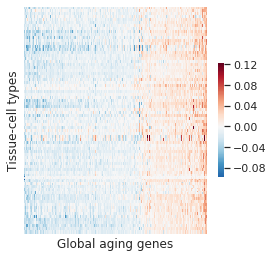

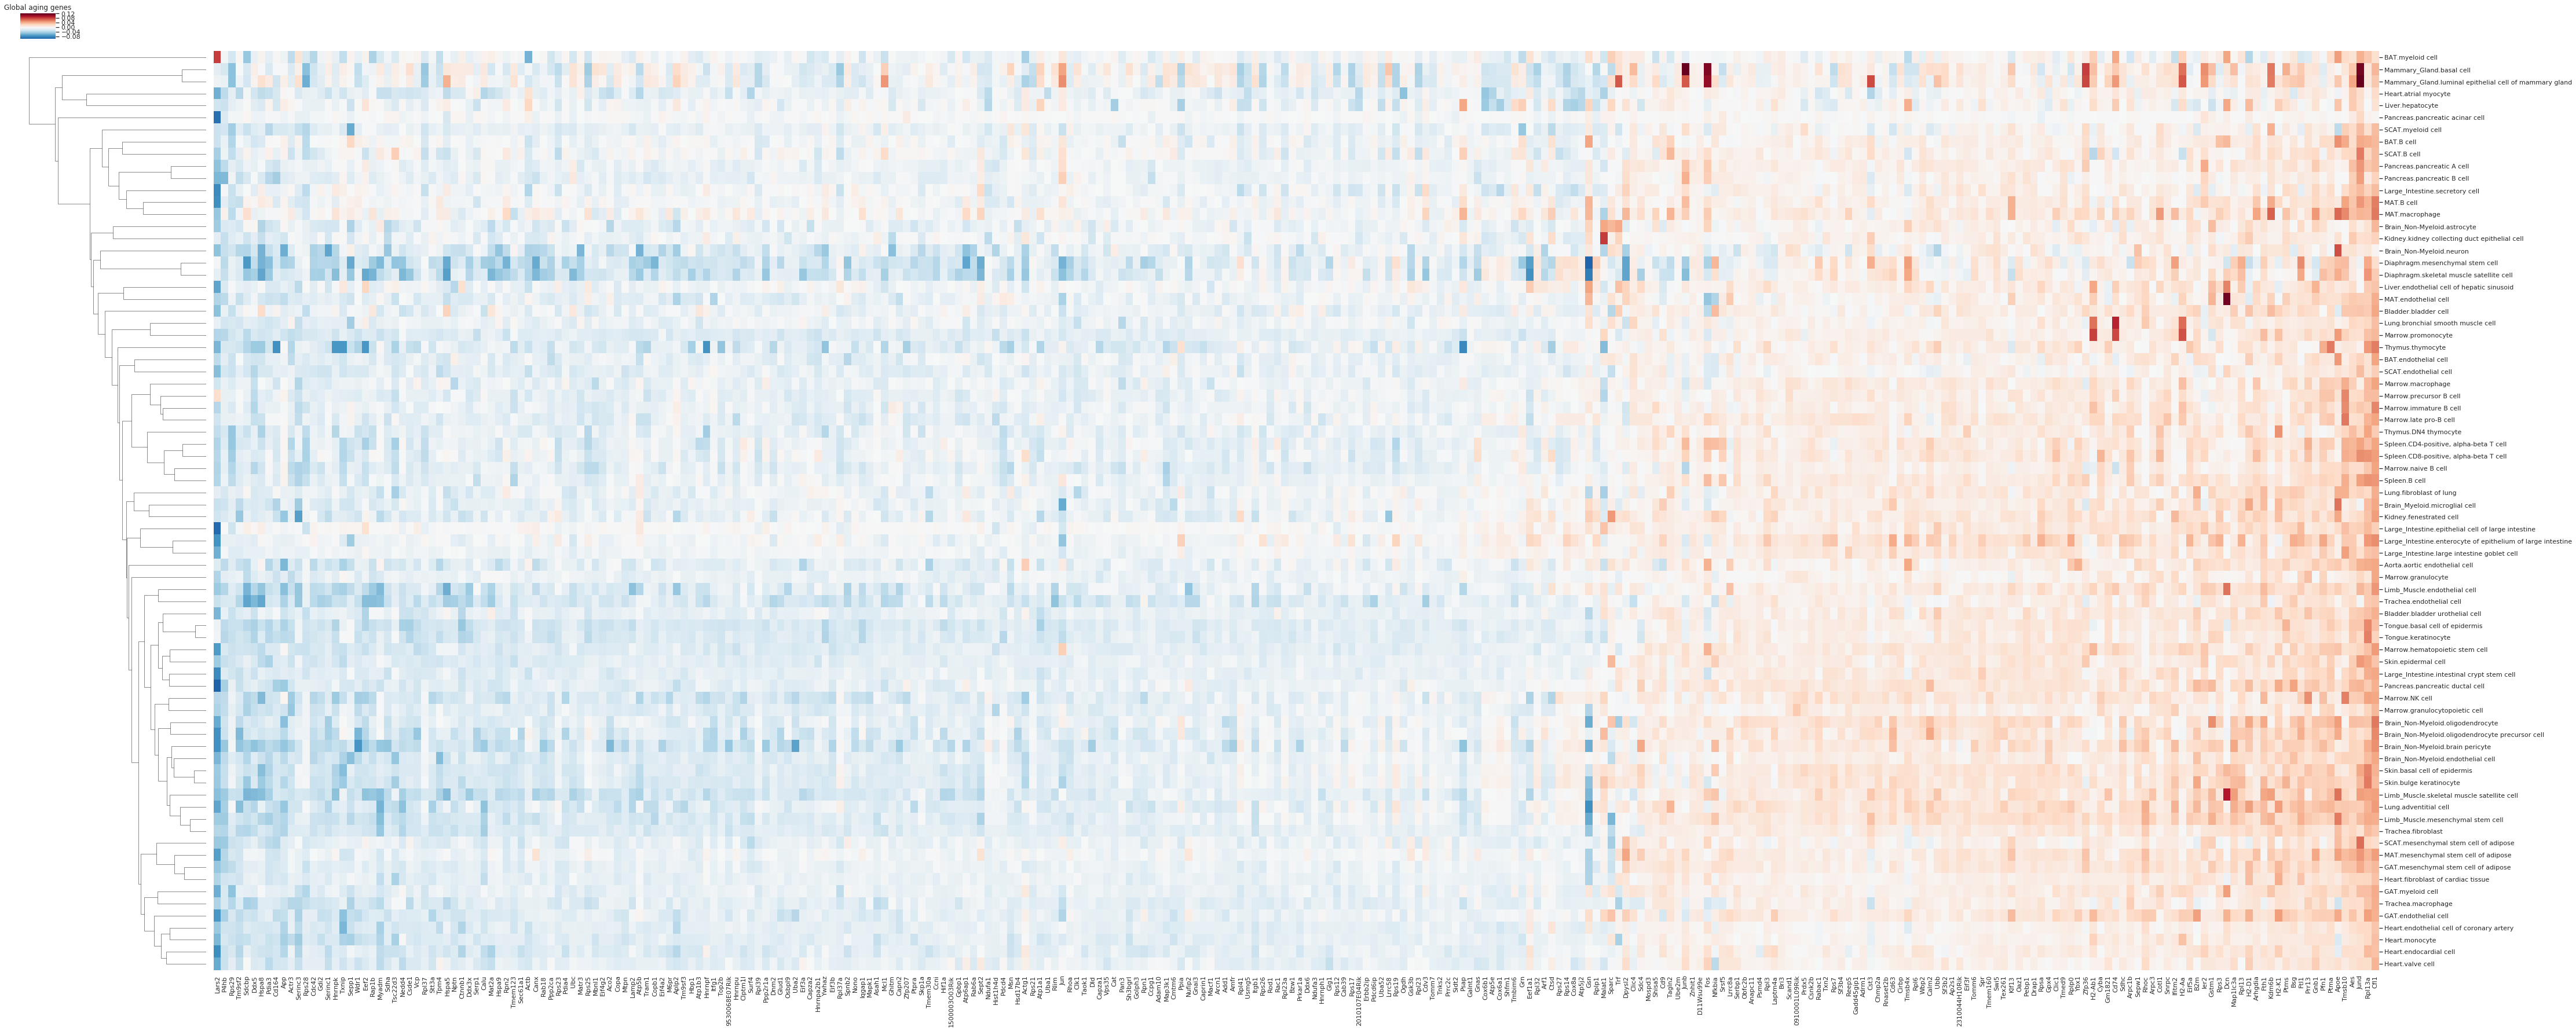

In [37]:
# Visualize global aging genes
# method = 'FACS'
global_aging_gene_list = dic_global_aging_gene['all']
temp_df = df_fc_MAST.loc[global_aging_gene_list]
temp_df = temp_df.fillna(value=0)
ind_sort = list(np.argsort(temp_df.mean(axis=1)))
temp_df = temp_df.iloc[ind_sort]
temp_df = temp_df.T
# visualization: overview
plt.figure(figsize = [0.014*temp_df.shape[1], 0.055*temp_df.shape[0]])
sns.heatmap(temp_df, xticklabels=False, yticklabels=False,
            cmap = 'RdBu_r', center=0, cbar_kws={"shrink": 0.5})
plt.xlabel('Global aging genes')
plt.ylabel('Tissue-cell types')
plt.savefig(output_folder_fig + '/tc_all_global_aging_gene_heatmap_small.pdf',
            transparent=True, bbox_inches='tight')
plt.show()
# visualization: whole
sns.clustermap(temp_df, xticklabels=True, yticklabels=True,
               row_cluster=True, metric='correlation', 
               col_cluster=False, 
               figsize = [0.25*temp_df.shape[1], 0.4*temp_df.shape[0]],
               cmap = 'RdBu_r', center=0)
plt.title('Global aging genes')
plt.savefig(output_folder_fig + '/tc_all_global_aging_gene_heatmap.pdf',
            transparent=True, bbox_inches='tight')
plt.show()

Index(['Tsc22d3', 'Hnrnpk', 'Jun', 'Ctnnb1', 'Hbp1', 'Gpbp1', 'Hif1a', 'Fos',
       'Junb', 'Ier2', 'Klf13', 'Ybx1', 'Jund'],
      dtype='object')


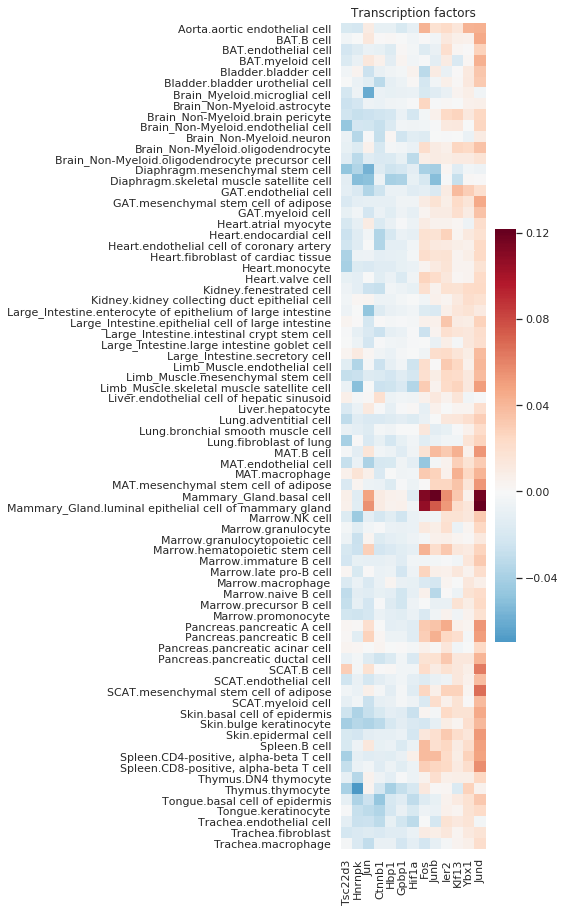

In [38]:
# TF genes
temp_f_name =  anno_data_folder + '/GO_term_summary_20171110_222852.csv'
temp_df = pd.read_csv(temp_f_name)
tf_list = list(set(temp_df['Symbol']) & set(df_global_aging_gene.index))
dic_interesting_gene_list['TF'] = tf_list.copy()
temp_df = df_global_aging_gene.loc[tf_list].copy()
gene_list_select = temp_df[temp_df['Prop. of Sig.']>0.5].index
# visualization
temp_df = df_fc_MAST.loc[gene_list_select]
temp_df = temp_df.fillna(value=0)
ind_sort = list(np.argsort(temp_df.median(axis=1)))
temp_df = temp_df.iloc[ind_sort]
temp_df = temp_df.T
# visualization: overview
print(temp_df.columns)
plt.figure(figsize = [0.25*temp_df.shape[1], 0.2*temp_df.shape[0]])
sns.heatmap(temp_df, xticklabels=True, yticklabels=True,
            cmap = 'RdBu_r', center=0, cbar_kws={"shrink": 0.5})
plt.title('Transcription factors')
plt.savefig(output_folder_fig + '/tc_TF_heatmap.pdf',
            transparent=True, bbox_inches='tight')
plt.show()

In [39]:
df_tf = pd.read_csv(temp_f_name)
df_tf.index = df_tf['Symbol']
df_tf = df_tf.loc[temp_df.columns, ['Annotated Term']]
for i_line in np.arange(df_tf.shape[0]):
    print(df_tf.index[i_line], df_tf.iloc[i_line]['Annotated Term'])

Tsc22d3 DNA binding transcription factor activity
Hnrnpk transcriptional activator activity, RNA polymerase II core promoter proximal region sequence-specific binding
Jun DNA binding transcription factor activity
Jun DNA binding transcription factor activity
Jun RNA polymerase II transcription factor activity, sequence-specific DNA binding
Jun transcription factor activity, RNA polymerase II core promoter proximal region sequence-specific binding
Jun transcription factor activity, RNA polymerase II distal enhancer sequence-specific binding
Jun transcriptional activator activity, RNA polymerase II core promoter proximal region sequence-specific binding
Ctnnb1 DNA binding transcription factor activity
Hbp1 transcriptional repressor activity, RNA polymerase II core promoter proximal region sequence-specific binding
Gpbp1 DNA binding transcription factor activity
Hif1a DNA binding transcription factor activity
Hif1a DNA binding transcription factor activity
Hif1a RNA polymerase II transcri

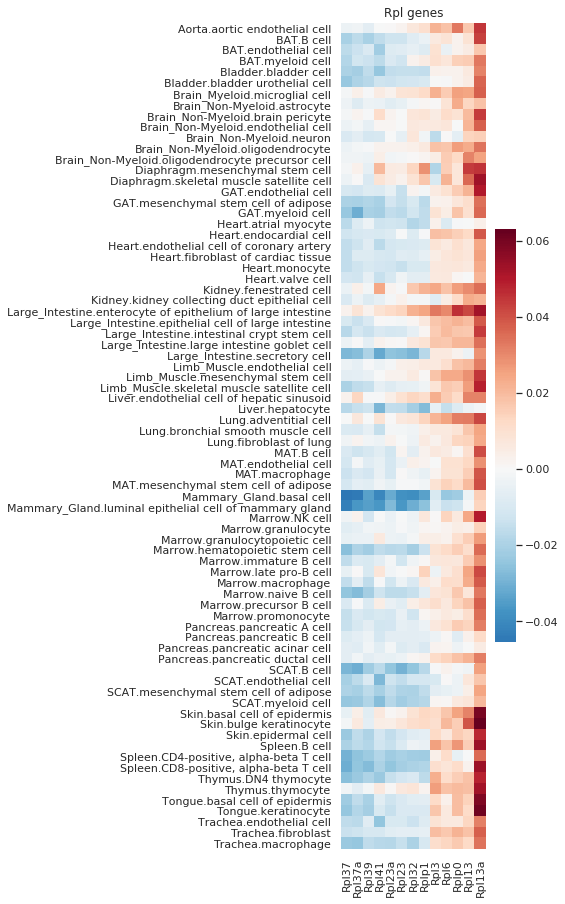

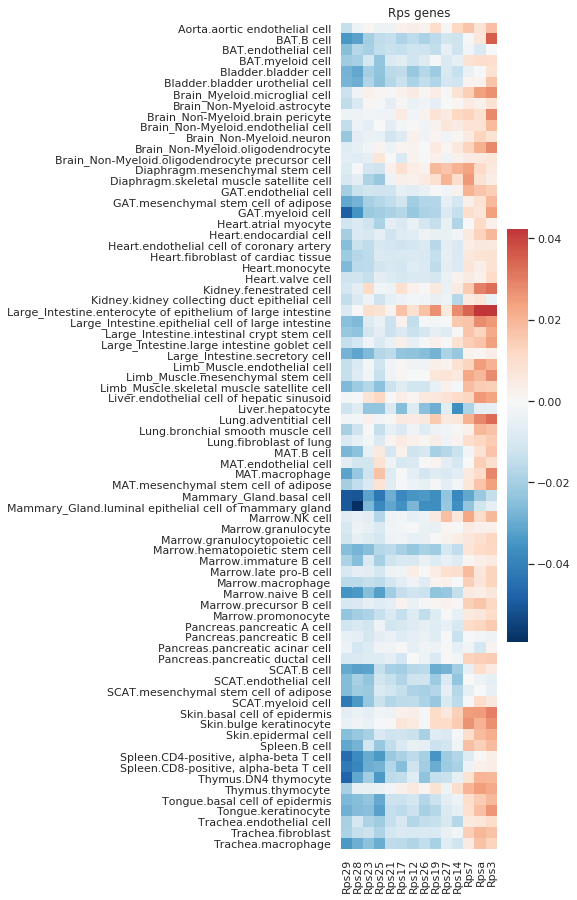

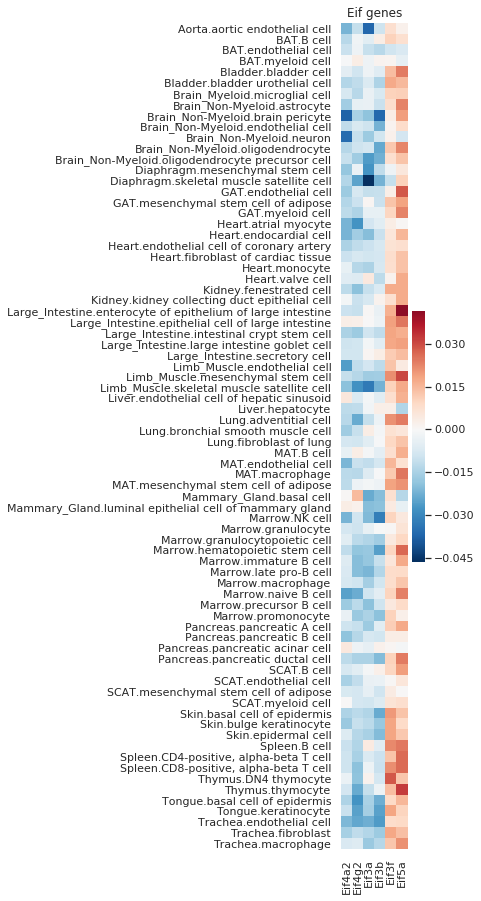

In [40]:
# Rpl and Eif
for gene_prefix in ['Rpl', 'Rps', 'Eif']:
    gene_list = np.array(temp_facs.var_names)
    temp_gene_mask = [x.startswith(gene_prefix) for x in gene_list]
    temp_gene_list = gene_list[temp_gene_mask]
    dic_interesting_gene_list[gene_prefix] = temp_gene_list.copy()
    temp_df = df_global_aging_gene.loc[temp_gene_list].copy()
    gene_list_select = temp_df[temp_df['Prop. of Sig.']>0.5].index
    # temp_gene_list = list(temp_df.index)
    # gene_list_select = temp_df[temp_df['Prop. of Sig.']>0.4].index
    # visualization
    temp_df = df_fc_MAST.loc[gene_list_select]
    temp_df = temp_df.fillna(value=0)
    ind_sort = list(np.argsort(temp_df.median(axis=1)))
    temp_df = temp_df.iloc[ind_sort]
    temp_df = temp_df.T
    # visualization: overview
    plt.figure(figsize = [0.25*temp_df.shape[1], 0.2*temp_df.shape[0]])
    sns.heatmap(temp_df, xticklabels=True, yticklabels=True,
                cmap = 'RdBu_r', center=0, cbar_kws={"shrink": 0.5})
    plt.title('%s genes'%gene_prefix)
    plt.savefig(output_folder_fig + '/tc_%s_heatmap.pdf'%gene_prefix,
                transparent=True, bbox_inches='tight')
    plt.show()

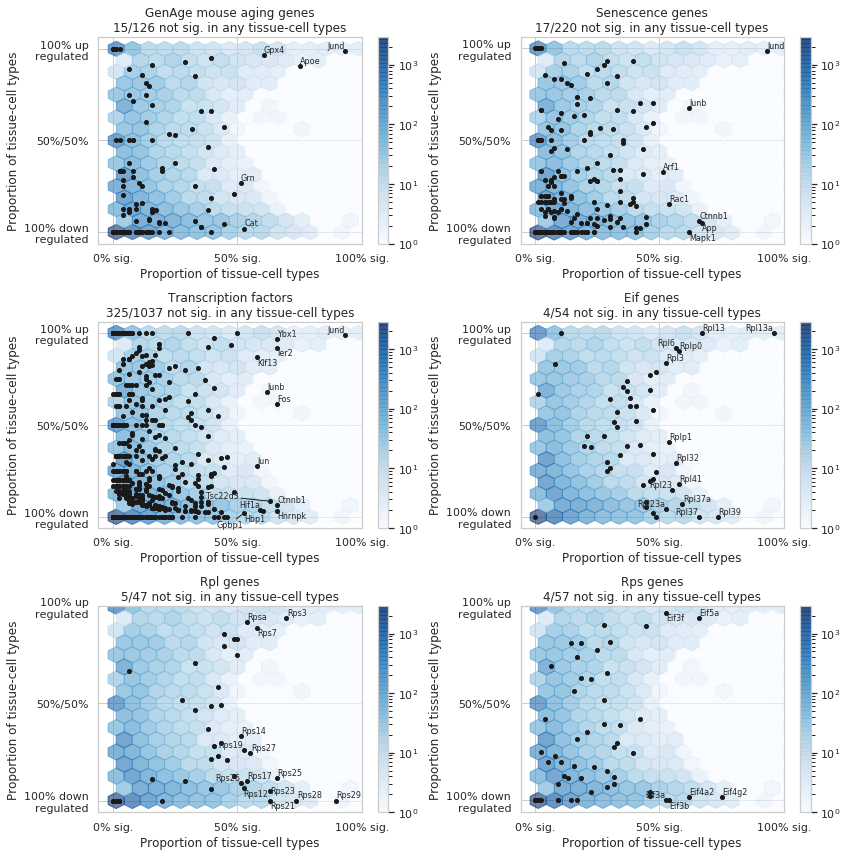

In [41]:
plt.figure(figsize=[12, 12])
title_list = ['GenAge mouse aging genes', 'Senescence genes', 'Transcription factors',
              'Eif genes', 'Rpl genes', 'Rps genes']
term_list = ['AgeGen', 'Senescence', 'TF', 'Eif', 'Rpl', 'Rps']
for i_term,term in enumerate(dic_interesting_gene_list.keys()):
    # corresponding scatter plot
    ind_global = df_global_aging_gene['Prop. of Sig.']>0
    temp_df = df_global_aging_gene.loc[ind_global]
#     plt.figure(figsize=[6,4])
    plt.subplot(3,2,i_term+1)
    plt.hexbin(temp_df['Prop. of Sig.'], temp_df['Prop. of +'], gridsize=15,
               cmap = 'Blues', bins='log', alpha=0.6)
    plt.colorbar()
    
    temp_df = df_global_aging_gene.loc[dic_interesting_gene_list[term]]
    plt.scatter(temp_df['Prop. of Sig.'], temp_df['Prop. of +'], color='k',
                alpha=1, s=16)
    
    # plt.ylabel('Proportion of tissue-cell types \nwhere the gene is up-regulated')
    plt.ylabel('Proportion of tissue-cell types')
    # plt.xlabel('Proportion of tissue-cell types \nwhere the gene has a significant aging effect')
    plt.xlabel('Proportion of tissue-cell types')
    plt.xticks([0, 0.5, 1], ['0% sig.', '50% sig.', '100% sig.'])
    plt.yticks([0, 0.5, 1], ['100% down\nregulated', '50%/50%', '100% up\nregulated'])
    
    texts = []
    ind_select = temp_df['Prop. of Sig.']>0.5
    for gene_name in temp_df.index[ind_select]:
        texts.append(plt.text(temp_df.loc[gene_name, 'Prop. of Sig.'],
                              temp_df.loc[gene_name, 'Prop. of +'],
                              gene_name, fontsize=8))
    adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k', lw=1))
    
    plt.title('%s\n%d/%d not sig. in any tissue-cell types'%(title_list[i_term], 
                           np.sum(temp_df['Prop. of Sig.']==0),
                           temp_df.shape[0]))
    plt.tight_layout()
plt.savefig(output_folder_fig + '/tc_scatter_interesting_genes.pdf',
            transparent=True)
plt.show()
#     break

### Comparison with tissue global genes

In [42]:
# Load the tissue-only data for comparison
with open(DE_result_path+'/DE_tissue_FACS.pickle', 'rb') as handle:
    DE_result_MAST_tissue = pickle.load(handle)
    analysis_list_tissue = pickle.load(handle)
    analysis_info_tissue = pickle.load(handle)
with open(DE_result_path+'/DE_tissue_droplet.pickle', 'rb') as handle:
    DE_result_MAST_tissue_droplet = pickle.load(handle)
    analysis_list_tissue_droplet = pickle.load(handle)
    analysis_info_tissue_droplet = pickle.load(handle)

In [43]:
gene_name_list = list(DE_result_MAST_tissue['BAT'].index)
df_bh_p_MAST_tissue = pd.DataFrame(index = gene_name_list)
df_fc_MAST_tissue = pd.DataFrame(index = gene_name_list)
for analyte in DE_result_MAST_tissue.keys():
    df_bh_p_MAST_tissue[analyte] = DE_result_MAST_tissue[analyte]['bh-p']
    df_fc_MAST_tissue[analyte] = DE_result_MAST_tissue[analyte]['coef']
df_global_aging_gene_tissue = pd.DataFrame(index = gene_name_list)
df_global_aging_gene_tissue['t.Prop. of Sig.'] = ((df_bh_p_MAST_tissue<0.01) & 
                                                (np.absolute(df_fc_MAST_tissue)>coef_threshold)).mean(axis=1)
df_global_aging_gene_tissue['t.Prop. of +'] = (df_fc_MAST_tissue>0).sum(axis=1) /\
                                        ((df_fc_MAST_tissue>0) | (df_fc_MAST_tissue<0)).sum(axis=1) 
df_global_aging_gene_tissue['t.Median fc'] = df_fc_MAST_tissue.median(axis=1)
df_global_aging_gene_tissue['t.Median bh-p'] = df_bh_p_MAST_tissue.median(axis=1)

In [44]:
df_comparison = df_global_aging_gene.copy()
df_comparison = df_comparison.join(df_global_aging_gene_tissue)

In [45]:
n_overlap = np.sum((df_comparison['Prop. of Sig.']>0.5) & 
                   (df_comparison['t.Prop. of Sig.']>0.8))
n_t_only = np.sum(df_comparison['t.Prop. of Sig.']>0.8) - n_overlap
n_tc_only = np.sum(df_comparison['Prop. of Sig.']>0.5) - n_overlap
print('Overlap:%d, tissue:%d, tissue_celltype:%d'%
      (n_overlap, n_t_only, n_tc_only))
# Fisher's exact test
temp_table = np.zeros([2,2], dtype=int)
temp_table[0,0] = temp_facs.shape[1] - n_t_only - n_tc_only - n_overlap
temp_table[0,1] = n_t_only
temp_table[1,0] = n_tc_only
temp_table[1,1] = n_overlap
print(temp_table)
sp.stats.fisher_exact(temp_table, alternative='greater')

Overlap:114, tissue:17, tissue_celltype:178
[[19533    17]
 [  178   114]]


(735.876404494382, 1.0875905209374943e-199)

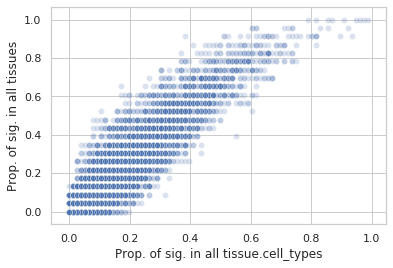

In [46]:
plt.figure()
sns.scatterplot(x='Prop. of Sig.', y='t.Prop. of Sig.', data=df_comparison, alpha=0.2)
plt.ylabel('Prop. of sig. in all tissues')
plt.xlabel('Prop. of sig. in all tissue.cell_types')
plt.show()

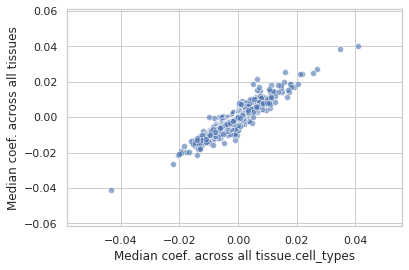

In [47]:
plt.figure()
sns.scatterplot(x='Median fc', y='t.Median fc', data=df_comparison, alpha=0.6)
plt.xlabel('Median coef. across all tissue.cell_types')
plt.ylabel('Median coef. across all tissues')
plt.show()

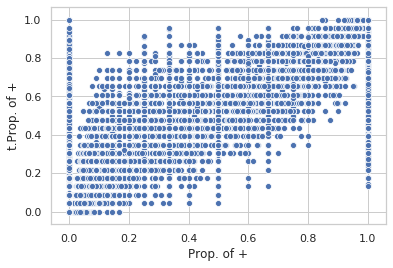

In [48]:
plt.figure()
sns.scatterplot(x='Prop. of +', y='t.Prop. of +', data=df_comparison)
plt.show()

### Aging gene scores of the tissue.cell_types

In [49]:
# compute an aging score: facs
sc.tl.score_genes(temp_facs, gene_list = dic_global_aging_gene['up'], score_name='score_up',
                  random_state=1)
sc.tl.score_genes(temp_facs, gene_list = dic_global_aging_gene['down'], score_name='score_down',
                  random_state=1)
temp_facs.obs['score'] = temp_facs.obs['score_up'] - temp_facs.obs['score_down']
# compute an aging score: droplet
sc.tl.score_genes(temp_droplet, gene_list = dic_global_aging_gene['up'], score_name='score_up',
                  random_state=1)
sc.tl.score_genes(temp_droplet, gene_list = dic_global_aging_gene['down'], score_name='score_down',
                  random_state=1)
temp_droplet.obs['score'] = temp_droplet.obs['score_up'] - temp_droplet.obs['score_down']

In [50]:
# Compare with the aging predictor by Peters et al ncomm 2015: load data
# data_folder = '/home/martin/maca/maca-data-analysis/analysis-scripts/data'
df_peter_predictor = pd.read_csv(anno_data_folder+'/peters_ncomm_2015_data5b.csv', sep=',',
                                 index_col=2)
gp = GProfiler(return_dataframe=True)
temp_gene = gp.orth(organism='hsapiens',
                    query=list(set(df_peter_predictor.index)),
                    target='mmusculus')
temp_gene.index = temp_gene['incoming']
df_peter_predictor = df_peter_predictor.join(temp_gene[['name']])
df_peter_predictor = df_peter_predictor.sort_values('order')
df_peter_predictor = df_peter_predictor.drop_duplicates(subset=['name'])
df_peter_predictor.index = df_peter_predictor['name']
df_peter_predictor = df_peter_predictor.loc[df_peter_predictor.index!='N/A']
# only keep genes in temp_facs
temp_gene_list = list(set(temp_facs.var_names) & set(df_peter_predictor.index))
df_peter_predictor = df_peter_predictor.loc[temp_gene_list]

In [51]:
# Compare with the aging predictor by Peters et al ncomm 2015:
# test for overlapping with global aging genes 
# significant ones have 'order'<1498
print('Comparing with global aging genes')
ind_select = df_peter_predictor['order']<1498
gene_list_peter = list(df_peter_predictor.index[ind_select])
temp_global_aging = list(set(dic_global_aging_gene['all']) & set(df_peter_predictor.index))
# Fisher's exact test
temp_table = np.zeros([2,2], dtype=int)
temp_table[0,0] = len(set(df_peter_predictor.index) - set(gene_list_peter) - 
                      set(temp_global_aging))
temp_table[0,1] = len(set(gene_list_peter) - set(temp_global_aging))
temp_table[1,0] = len(set(temp_global_aging) - set(gene_list_peter))
temp_table[1,1] = len(set(temp_global_aging) & set(gene_list_peter))
print(temp_table)
print(sp.stats.fisher_exact(temp_table, alternative='greater'))
# 
for cate in dic_tc_specific_gene.keys():
    if len(dic_tc_specific_gene[cate])<5:
        continue
    print('Comparing with %s-specific genes'%cate)
    temp_global_aging = list(set(dic_tc_specific_gene[cate]) & set(df_peter_predictor.index))
    # Fisher's exact test
    temp_table = np.zeros([2,2], dtype=int)
    temp_table[0,0] = len(set(df_peter_predictor.index) - set(gene_list_peter) - 
                          set(temp_global_aging))
    temp_table[0,1] = len(set(gene_list_peter) - set(temp_global_aging))
    temp_table[1,0] = len(set(temp_global_aging) - set(gene_list_peter))
    temp_table[1,1] = len(set(temp_global_aging) & set(gene_list_peter))
    print(temp_table)
    print(sp.stats.fisher_exact(temp_table, alternative='greater'))

Comparing with global aging genes
[[8582 1294]
 [ 183   34]]
(1.2322024307227135, 0.15740712712690572)
Comparing with immune-specific genes
[[8645 1280]
 [ 120   48]]
(2.7015625, 8.345578263308544e-08)
Comparing with stem cell/progenitor-specific genes
[[8663 1310]
 [ 102   18]]
(1.166995958688819, 0.3120338505133609)
Comparing with endothelial-specific genes
[[8726 1315]
 [  39   13]]
(2.21191381495564, 0.015052261818127266)


In [52]:
import statsmodels.formula.api as sm
# Compare with the aging predictor by Peters et al ncomm 2015:
# Compute an aging score based on the predictor
temp_data = temp_facs[:,temp_gene_list]
# regress out sex as in the receipe (too slow, regress after the aging score instead)
# sc.pp.regress_out(temp_data, 'sex')
temp_coef = np.array(df_peter_predictor.loc[temp_gene_list, 'PREDICTOR-for-NEW-COHORTS'])
temp_peter_age = temp_data.X.dot(temp_coef)
temp_facs.obs['score_peters'] = temp_peter_age
# regress out chronological age and sex and interaction
temp_facs.obs['score_regout_peters'] = 0
temp_df_lr = temp_facs.obs.copy()
result = sm.ols(formula="score_peters ~ age + sex + age*sex", data=temp_df_lr).fit()
temp_facs.obs['score_regout_peters'] = result.resid
print('aging score in Peters et al 2015\n', result.params)
print('')

aging score in Peters et al 2015
 Intercept                 0.174123
age[T.24m]               -0.002437
age[T.3m]                 0.004150
sex[T.male]              -0.024826
age[T.24m]:sex[T.male]   -0.002437
age[T.3m]:sex[T.male]     0.031031
dtype: float64



In [53]:
# get the number of cell types for both facs and droplet
category_list = []
for x in df_cell_category['cell category']:
    category_list += x.split(';')
category_list = list(set(category_list))
category_list.sort()
df_cell_cate_annotation = pd.DataFrame(index=category_list, columns=['n_celltype'], data=0)
for cate in category_list:
    ind_select =  [cate in x for x in df_cell_category['cell category']] 
    df_cell_cate_annotation.loc[cate, 'n_celltype'] = np.sum(ind_select)
# add n_celltype
temp_facs.obs['n_celltype'] = 0
temp_droplet.obs['n_celltype'] = 0
for analyte in analysis_list:
    cate_list = df_cell_category.loc[analyte, 'cell category'].split(';')
    mean_n_celltype = np.mean(df_cell_cate_annotation.loc[cate_list, 'n_celltype'])
    # FACS
    ind_select = temp_facs.obs['analyte']==analyte
    temp_facs.obs.loc[ind_select, 'n_celltype'] = mean_n_celltype
    # Droplet
    ind_select = temp_droplet.obs['analyte']==analyte
    temp_droplet.obs.loc[ind_select, 'n_celltype'] = mean_n_celltype
# ind of cells that are included in the analysis 
ind_analysis = temp_facs.obs['n_celltype']>0
print('FACS', np.sum(ind_analysis)/temp_facs.shape[0])
ind_analysis_droplet = temp_droplet.obs['n_celltype']>0
print('droplet', np.sum(ind_analysis_droplet)/temp_droplet.shape[0])

FACS 0.8249276019678309
droplet 0.41041538298098373


In [54]:
# Regress out sex and age (and n_cell_type)
import statsmodels.formula.api as sm
# facs
temp_facs.obs['score_regout'] = 0
temp_df_lr = temp_facs.obs.copy()
result = sm.ols(formula="score ~ age + sex + age*sex", data=temp_df_lr).fit()
temp_facs.obs['score_regout'] = result.resid
print('facs\n', result.params)
print('')
# facs: regress out n_celltype
temp_facs.obs['score_regout_n_celltype'] = 0
temp_df_lr = temp_facs.obs.loc[ind_analysis]
result = sm.ols(formula="score ~ age + sex + age*sex + n_celltype", data=temp_df_lr).fit()
temp_facs.obs.loc[ind_analysis, 'score_regout_n_celltype'] = result.resid
print('facs, n_celltype\n', result.params)
print('')
# droplet
temp_droplet.obs['score_regout'] = 0
temp_df_lr = temp_droplet.obs.copy()
result = sm.ols(formula="score ~ age + sex + age*sex", data=temp_df_lr).fit()
temp_droplet.obs['score_regout'] = result.resid
print('droplet\n', result.params)
print('')
# droplet: regress out n_celltype
temp_droplet.obs['score_regout_n_celltype'] = 0
temp_df_lr = temp_droplet.obs.loc[ind_analysis_droplet]
result = sm.ols(formula="score ~ age + sex + age*sex + n_celltype", data=temp_df_lr).fit()
temp_droplet.obs.loc[ind_analysis_droplet, 'score_regout_n_celltype'] = result.resid
print('droplet, n_celltype\n', result.params)
print('')

facs
 Intercept                 0.470175
age[T.24m]                0.032099
age[T.3m]                -0.224041
sex[T.male]               0.073420
age[T.24m]:sex[T.male]    0.032099
age[T.3m]:sex[T.male]    -0.240392
dtype: float64

facs, n_celltype
 Intercept                 0.523340
age[T.24m]                0.032754
age[T.3m]                -0.225451
sex[T.male]               0.080080
age[T.24m]:sex[T.male]    0.032754
age[T.3m]:sex[T.male]    -0.241813
n_celltype               -0.003209
dtype: float64

droplet
 Intercept                 1.639711e-01
age[T.1m]                -1.392438e+06
age[T.21m]                3.366678e-02
age[T.24m]               -8.842006e+09
age[T.30m]               -6.172251e+09
age[T.3m]                -2.360350e-02
sex[T.male]              -1.834895e-03
age[T.1m]:sex[T.male]     1.392438e+06
age[T.21m]:sex[T.male]   -4.028838e-06
age[T.24m]:sex[T.male]    8.842006e+09
age[T.30m]:sex[T.male]    6.172251e+09
age[T.3m]:sex[T.male]    -1.166752e-03
dtype: float

In [55]:
# facs aging score (regress out age and sex)
df_aging_score = temp_facs.obs.groupby(['analyte']).agg({'score_regout':'mean',
                                                         'score_regout_n_celltype':'mean',
                                                         'cell':len,
                                                         'score_regout_peters':'mean'})
df_aging_score = df_aging_score.loc[analysis_list].copy()
df_aging_score = df_aging_score.sort_values(by='score_regout')
df_aging_score['analyte'] = df_aging_score.index
df_aging_score['loc'] = np.arange(df_aging_score.shape[0])
df_aging_score['# of Sig. global aging'] = [np.sum(df_global_aging_gene.loc
                                                   [dic_global_aging_gene['all'], 
                                                    '%s.Sig.'%x])
                                            for x in df_aging_score.index]
df_aging_score = df_aging_score.join(df_analysis[['n_rej']])
df_aging_score = df_aging_score.join(df_cell_category)
# droplet aging score (regress out age and sex)
df_aging_score_droplet = temp_droplet.obs.groupby(['analyte']).agg({'score_regout':'mean',
                                                         'score_regout_n_celltype':'mean',
                                                         'cell':len})
df_aging_score_droplet = df_aging_score_droplet.loc[analysis_list_droplet].copy()
df_aging_score_droplet = df_aging_score_droplet.sort_values(by='score_regout')
df_aging_score_droplet['analyte'] = df_aging_score_droplet.index
df_aging_score_droplet['loc'] = np.arange(df_aging_score_droplet.shape[0])
df_aging_score_droplet = df_aging_score_droplet.join(df_cell_category)

In [56]:
# Visualize the aging score for different cell categories 
category_list = []
for x in df_aging_score['cell category']:
    category_list += x.split(';')
category_list = list(set(category_list))
category_list.remove('muscle cell')
df_aging_score_cate = pd.DataFrame(index=category_list, 
                                   columns = ['mean_score', 'std_score', 
                                              'mean_score_n_cell_type', 
                                              'std_score_n_cell_type',
                                              'n_celltype', 'mean_#_sig_global'],
                                   data=0)
for cate in category_list:
    ind_select =  [cate in x for x in df_aging_score['cell category']]
    temp_list_cell_cate = df_aging_score.index[ind_select]
    df_aging_score_cate.loc[cate, ['mean_score']] = \
        np.mean(df_aging_score['score_regout'][ind_select])
    df_aging_score_cate.loc[cate, ['std_score']] = \
        np.std(df_aging_score['score_regout'][ind_select])/np.sqrt(np.sum(ind_select))
    df_aging_score_cate.loc[cate, ['mean_score_n_cell_type']] = \
        np.mean(df_aging_score['score_regout_n_celltype'][ind_select])
    df_aging_score_cate.loc[cate, ['std_score_n_cell_type']] = \
        np.std(df_aging_score['score_regout_n_celltype'][ind_select])/np.sqrt(np.sum(ind_select))
    df_aging_score_cate.loc[cate, ['n_celltype']] = np.sum(ind_select)
    # 
    df_aging_score_cate.loc[cate, ['mean_#_sig_global']] = \
        np.mean(df_aging_score.loc[ind_select, '# of Sig. global aging'])    
df_aging_score_cate = df_aging_score_cate.sort_values(by='mean_score', ascending=False)
category_list = df_aging_score_cate.index

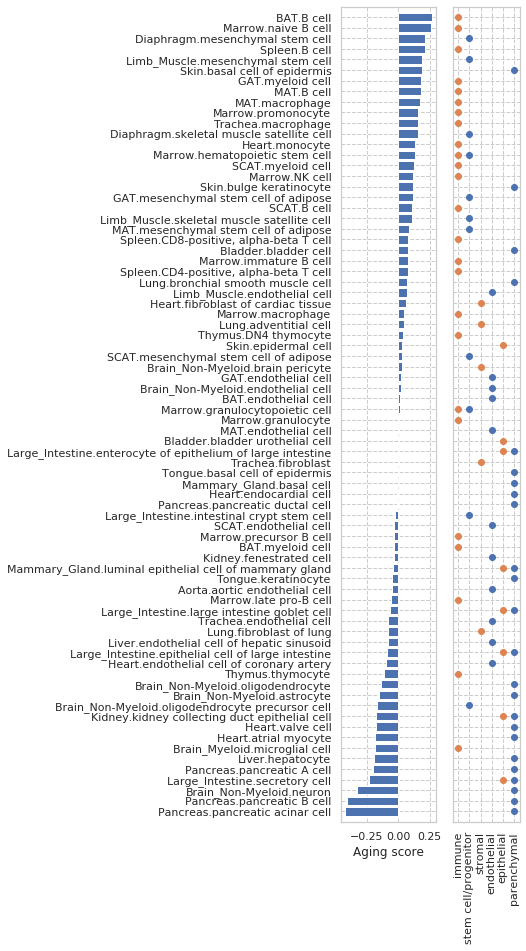

In [57]:
from matplotlib import gridspec
y_min,y_max = -1, df_aging_score.shape[0]
plt.figure(figsize=[3.2,15])
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 0.7]) 
plt.subplot(gs[0])
plt.barh(df_aging_score['loc'], df_aging_score['score_regout'])
plt.ylim([y_min, y_max])
plt.xlabel('Aging score')
plt.yticks(df_aging_score['loc'], df_aging_score['analyte'])
plt.grid(True, linestyle='--')
plt.subplot(gs[1])
for i_cate,cate in enumerate(category_list):
    temp_color = 'C1' if i_cate%2==0 else 'C0'
    ind_select = df_aging_score['cell category']==cate
    ind_select = [cate in x for x in df_aging_score['cell category']]
    plt.scatter([i_cate]*np.sum(ind_select), df_aging_score.loc[ind_select, 'loc'],
                color = temp_color)
plt.xticks(np.arange(len(category_list)), category_list, rotation=90)
plt.ylim([y_min, y_max])
plt.xlim([-0.5, len(category_list)-0.5])
plt.yticks(np.arange(df_aging_score.shape[0]), ['']*df_aging_score.shape[0])
plt.grid(True, linestyle='--')
plt.grid(True, which='major', axis='x')
plt.savefig(output_folder_fig + '/tc_aging_score_FACS.pdf',
            transparent=True, bbox_inches='tight')
plt.show()

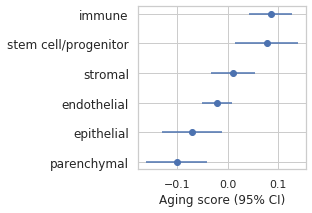

In [58]:
plt.figure(figsize=[3,3])
plt.errorbar(df_aging_score_cate['mean_score'], np.arange(df_aging_score_cate.shape[0])[::-1], 
             xerr=1.96*df_aging_score_cate['std_score'], linestyle='',
             marker='o')
plt.yticks(np.arange(df_aging_score_cate.shape[0])[::-1],
           df_aging_score_cate.index, rotation=0, fontsize=12)
plt.xlabel('Aging score (95% CI)')
plt.savefig(output_folder_fig + '/tc_aging_score_FACS_by_cate.pdf',
            transparent=True, bbox_inches='tight')
plt.show()

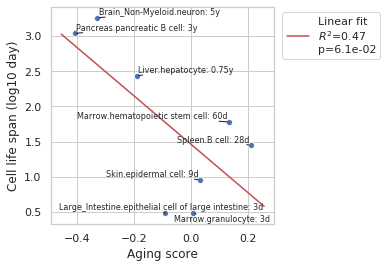

In [59]:
# correlation with cell turnover rate
plt.figure(figsize=[4,4])
temp_df = df_aging_score.loc[df_aging_score['turnover rate in mouse']!=''].copy()
temp_df['turnover rate num'] = [np.log10(float(x[:-1])) if x[-1]=='d' else
                                np.log10(float(x[:-1])*365) 
                                for x in temp_df['turnover rate in mouse']]

sns.scatterplot(data=temp_df, x='score_regout', y='turnover rate num')
# linear fit
sl, icpt, r_val, p_val, _ = sp.stats.linregress(temp_df['score_regout'], 
                                                temp_df['turnover rate num'])
x_min,x_max = plt.xlim()
y_min,y_max = plt.ylim()
plt.plot([x_min, x_max], [x_min*sl + icpt, x_max*sl + icpt], color='r',
         label='Linear fit\n$R^2$=%0.2f\np=%0.1e'%(r_val**2, p_val))
plt.legend(bbox_to_anchor=[1.5,1])

texts = []
for analyte in temp_df.index:
    texts.append(plt.text(temp_df.loc[analyte, 'score_regout'],
                          temp_df.loc[analyte, 'turnover rate num'],
                          '%s: %s'%(analyte, temp_df.loc[analyte, 'turnover rate in mouse']),
                          fontsize=8))
adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k', lw=1))

plt.ylabel('Cell life span (log10 day)')
plt.xlabel('Aging score')
plt.savefig(output_folder_fig + '/tc_aging_score_turnover_rate.pdf',
            transparent=True, bbox_inches='tight')
plt.show()

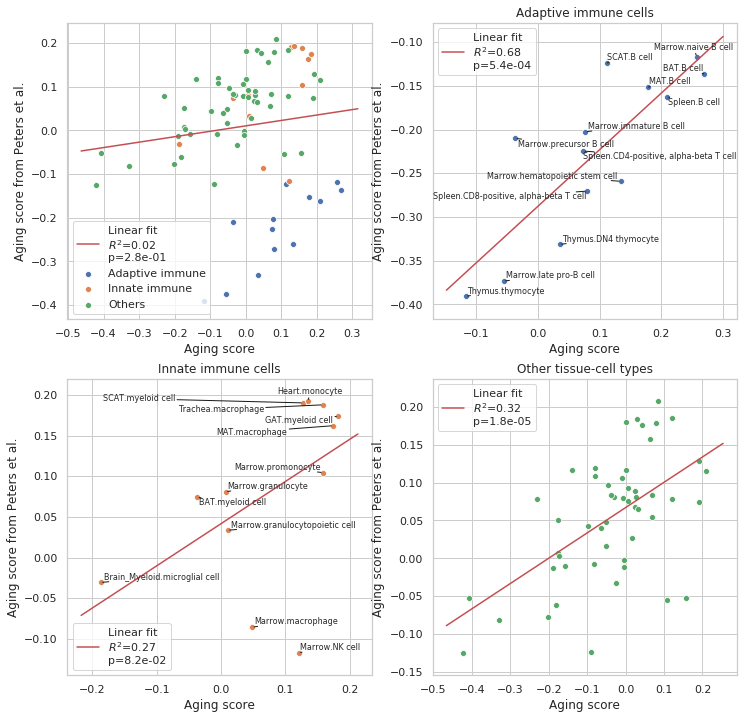

In [60]:
# Comparing with the aging score in Peters et al.
ind_select = ['immune' in x.split(';') for x in df_cell_category['cell category']]
analyte_list = df_cell_category.index[ind_select]
adaptive_immune_list = ['BAT.B cell', 'MAT.B cell', 'Marrow.hematopoietic stem cell',
                        'Marrow.immature B cell', 'Marrow.late pro-B cell',
                        'Marrow.naive B cell', 'Marrow.precursor B cell',
                        'SCAT.B cell', 'Spleen.B cell',
                        'Spleen.CD4-positive, alpha-beta T cell',
                        'Spleen.CD8-positive, alpha-beta T cell',
                        'Thymus.DN4 thymocyte', 'Thymus.thymocyte']
innate_immune_list = list(set(analyte_list) - set(adaptive_immune_list))
rest_list = list(set(df_cell_category.index) - set(analyte_list)
                 - set(adaptive_immune_list))

plt.figure(figsize=[12,12])
plt.subplot(221)
sns.scatterplot(data=df_aging_score.loc[adaptive_immune_list],
                x='score_regout', y='score_regout_peters', label='Adaptive immune', color='C0')
sns.scatterplot(data=df_aging_score.loc[innate_immune_list],
                x='score_regout', y='score_regout_peters', label='Innate immune', color='C1')
sns.scatterplot(data=df_aging_score.loc[rest_list],
                x='score_regout', y='score_regout_peters', label='Others', color='C2')
# linear fit
sl, icpt, r_val, p_val, _ = sp.stats.linregress(df_aging_score['score_regout'], 
                                                df_aging_score['score_regout_peters'])
x_min,x_max = plt.xlim()
y_min,y_max = plt.ylim()
plt.plot([x_min, x_max], [x_min*sl + icpt, x_max*sl + icpt], color='r',
         label='Linear fit\n$R^2$=%0.2f\np=%0.1e'%(r_val**2, p_val))
plt.legend()
plt.xlabel('Aging score')
plt.ylabel('Aging score from Peters et al.')

plt.subplot(222)
sns.scatterplot(data=df_aging_score.loc[adaptive_immune_list],
                x='score_regout', y='score_regout_peters', color='C0')
# linear fit
sl, icpt, r_val, p_val, _ = sp.stats.linregress(df_aging_score.loc[adaptive_immune_list, 'score_regout'], 
                                                df_aging_score.loc[adaptive_immune_list, 'score_regout_peters'])
x_min,x_max = plt.xlim()
y_min,y_max = plt.ylim()
plt.plot([x_min, x_max], [x_min*sl + icpt, x_max*sl + icpt], color='r',
         label='Linear fit\n$R^2$=%0.2f\np=%0.1e'%(r_val**2, p_val))
plt.legend()
plt.xlabel('Aging score')
plt.ylabel('Aging score from Peters et al.')
plt.title('Adaptive immune cells')

texts = []
for analyte in adaptive_immune_list:
    texts.append(plt.text(df_aging_score.loc[analyte, 'score_regout'],
                          df_aging_score.loc[analyte, 'score_regout_peters'],
                          '%s'%(analyte), fontsize=8))
adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k', lw=1))

plt.subplot(223)
sns.scatterplot(data=df_aging_score.loc[innate_immune_list],
                x='score_regout', y='score_regout_peters', color='C1')
# linear fit
sl, icpt, r_val, p_val, _ = sp.stats.linregress(df_aging_score.loc[innate_immune_list, 'score_regout'], 
                                                df_aging_score.loc[innate_immune_list, 'score_regout_peters'])
x_min,x_max = plt.xlim()
y_min,y_max = plt.ylim()
plt.plot([x_min, x_max], [x_min*sl + icpt, x_max*sl + icpt], color='r',
         label='Linear fit\n$R^2$=%0.2f\np=%0.1e'%(r_val**2, p_val))
plt.legend(loc='lower left')
plt.xlabel('Aging score')
plt.ylabel('Aging score from Peters et al.')
plt.title('Innate immune cells')

texts = []
for analyte in innate_immune_list:
    texts.append(plt.text(df_aging_score.loc[analyte, 'score_regout'],
                          df_aging_score.loc[analyte, 'score_regout_peters'],
                          '%s'%(analyte), fontsize=8))
adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k', lw=1))

plt.subplot(224)
sns.scatterplot(data=df_aging_score.loc[rest_list],
                x='score_regout', y='score_regout_peters', color='C2')
# linear fit
sl, icpt, r_val, p_val, _ = sp.stats.linregress(df_aging_score.loc[rest_list, 'score_regout'], 
                                                df_aging_score.loc[rest_list, 'score_regout_peters'])
x_min,x_max = plt.xlim()
y_min,y_max = plt.ylim()
plt.plot([x_min, x_max], [x_min*sl + icpt, x_max*sl + icpt], color='r',
         label='Linear fit\n$R^2$=%0.2f\np=%0.1e'%(r_val**2, p_val))
plt.legend()
plt.xlabel('Aging score')
plt.ylabel('Aging score from Peters et al.')
plt.title('Other tissue-cell types')

plt.savefig(output_folder_fig + '/tc_aging_score_peter.pdf',
            transparent=True, bbox_inches='tight')
plt.show()

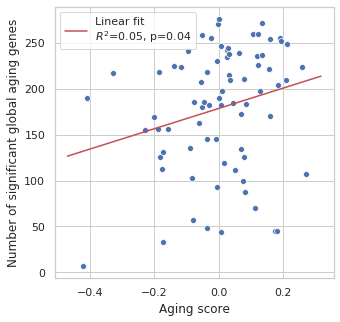

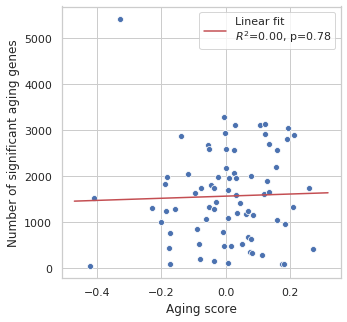

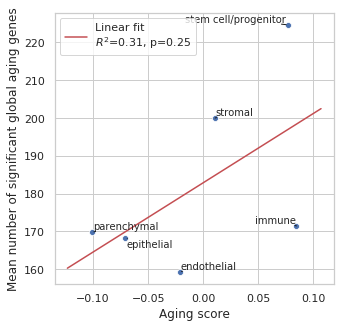

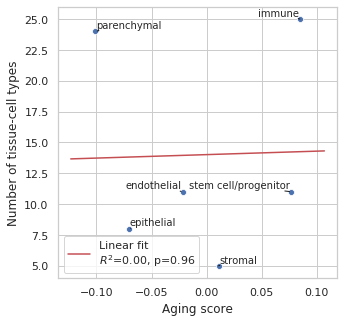

In [66]:
# Confounding factors
# # of significant global aging gene v.s. aging score
plt.figure(figsize=[5,5])
sns.scatterplot(data=df_aging_score, x='score_regout', y='# of Sig. global aging')
# linear fit
sl, icpt, r_val, p_val, _ = sp.stats.linregress(df_aging_score['score_regout'], 
                                                df_aging_score['# of Sig. global aging'])
x_min,x_max = plt.xlim()
y_min,y_max = plt.ylim()
plt.plot([x_min, x_max], [x_min*sl + icpt, x_max*sl + icpt], color='r',
         label='Linear fit\n$R^2$=%0.2f, p=%0.2f'%(r_val**2, p_val))
plt.legend()
plt.xlabel('Aging score')
plt.ylabel('Number of significant global aging genes')
plt.savefig(output_folder_fig + '/tc_aging_score_by_mean_#_sig_global.pdf',
            transparent=True, bbox_inches='tight')
plt.show()

# # of significant global aging gene v.s. aging score
plt.figure(figsize=[5,5])
sns.scatterplot(data=df_aging_score, x='score_regout', y='n_rej')
# linear fit
sl, icpt, r_val, p_val, _ = sp.stats.linregress(df_aging_score['score_regout'], 
                                                df_aging_score['n_rej'])
x_min,x_max = plt.xlim()
y_min,y_max = plt.ylim()
plt.plot([x_min, x_max], [x_min*sl + icpt, x_max*sl + icpt], color='r',
         label='Linear fit\n$R^2$=%0.2f, p=%0.2f'%(r_val**2, p_val))
plt.legend()
plt.xlabel('Aging score')
plt.ylabel('Number of significant aging genes')
plt.savefig(output_folder_fig + '/tc_aging_score_by_n_rej.pdf',
            transparent=True, bbox_inches='tight')
plt.show()

plt.figure(figsize=[5,5])
sns.scatterplot(data=df_aging_score_cate, x='mean_score', y='mean_#_sig_global')
# linear fit
sl, icpt, r_val, p_val, _ = sp.stats.linregress(df_aging_score_cate['mean_score'], 
                                                df_aging_score_cate['mean_#_sig_global'])
x_min,x_max = plt.xlim()
y_min,y_max = plt.ylim()
plt.plot([x_min, x_max], [x_min*sl + icpt, x_max*sl + icpt], color='r',
         label='Linear fit\n$R^2$=%0.2f, p=%0.2f'%(r_val**2, p_val))
plt.legend()
# annotation
texts = []
for cell_cate in df_aging_score_cate.index:
    texts.append(plt.text(df_aging_score_cate.loc[cell_cate, 'mean_score'],
                          df_aging_score_cate.loc[cell_cate, 'mean_#_sig_global'],
                          cell_cate, fontsize=10))
adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k', lw=1))
plt.xlabel('Aging score')
plt.ylabel('Mean number of significant global aging genes')
plt.savefig(output_folder_fig + '/tc_aging_score_by_mean_#_sig_global_cell_cate.pdf',
            transparent=True, bbox_inches='tight')
plt.show()

# 
plt.figure(figsize=[5,5])
sns.scatterplot(data=df_aging_score_cate, x='mean_score', y='n_celltype')
# linear fit
sl, icpt, r_val, p_val, _ = sp.stats.linregress(df_aging_score_cate['mean_score'], 
                                                df_aging_score_cate['n_celltype'])
x_min,x_max = plt.xlim()
y_min,y_max = plt.ylim()
plt.plot([x_min, x_max], [x_min*sl + icpt, x_max*sl + icpt], color='r',
         label='Linear fit\n$R^2$=%0.2f, p=%0.2f'%(r_val**2, p_val))
plt.legend()
# annotation
texts = []
for cell_cate in df_aging_score_cate.index:
    texts.append(plt.text(df_aging_score_cate.loc[cell_cate, 'mean_score'],
                          df_aging_score_cate.loc[cell_cate, 'n_celltype'],
                          cell_cate, fontsize=10))
adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k', lw=1))
plt.xlabel('Aging score')
plt.ylabel('Number of tissue-cell types')
plt.savefig(output_folder_fig + '/tc_aging_score_by_n_celltype.pdf',
            transparent=True, bbox_inches='tight')
plt.show()

In [62]:
# Comparison between the two technologies: reimplement
analyte_list = list(set(df_aging_score['analyte']) | set(df_aging_score_droplet['analyte']))
temp_comparison = pd.DataFrame(index = analyte_list)
method_list = ['FACS', 'droplet']
for method in method_list:
    temp_comparison['score_regout.%s'%(method)] = -1
    temp_comparison['n_cell.%s'%(method)] = -1
for analyte in temp_comparison.index:
    # FACS
    ind_select = (temp_facs.obs['analyte']==analyte)
    if np.sum(ind_select)>0:
        temp_comparison.loc[analyte, 'score_regout.FACS'] = \
            np.mean(temp_facs.obs['score_regout'][ind_select])
        temp_comparison.loc[analyte, 'n_cell.FACS'] = \
            np.sum(ind_select)
    # droplet
    ind_select = (temp_droplet.obs['analyte']==analyte)
    if np.sum(ind_select)>0:
        temp_comparison.loc[analyte, 'score_regout.droplet'] = \
            np.mean(temp_droplet.obs['score_regout'][ind_select])
        temp_comparison.loc[analyte, 'n_cell.droplet'] = \
            np.sum((temp_droplet.obs['analyte']==analyte))
temp_comparison = temp_comparison.loc[(temp_comparison!=-1).sum(axis=1)>0]
ind_select = np.array(['nan' not in x for x in temp_comparison.index])
temp_comparison = temp_comparison.loc[ind_select]

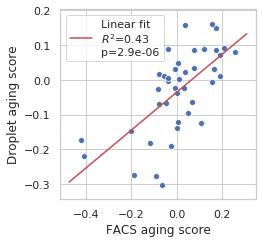

In [63]:
comparison_list = ['FACS;droplet']
for comparison in comparison_list:
    method1,method2 = comparison.split(';')
    ind_select = (temp_comparison[['score_regout.%s'%(method1),
                                   'score_regout.%s'%(method2)]]==-1).sum(axis=1)==0
    plt.figure(figsize=[3.5,3.5])
    sns.scatterplot(x='score_regout.%s'%(method1), y='score_regout.%s'%(method2),
                    data=temp_comparison.loc[ind_select])
    x_val = np.array(temp_comparison.loc[ind_select, 'score_regout.%s'%(method1)],
                     dtype=float)
    y_val = np.array(temp_comparison.loc[ind_select, 'score_regout.%s'%(method2)],
                     dtype=float)                                 
    sl, icpt, r_val, p_val, _ = sp.stats.linregress(x_val, y_val)
    # linear fit
    x_min,x_max = plt.xlim()
    y_min,y_max = plt.ylim()
    plt.plot([x_min, x_max], [x_min*sl + icpt, x_max*sl + icpt], color='r',
             label='Linear fit\n$R^2$=%0.2f\np=%0.1e'%(r_val**2, p_val))
    plt.legend()
    plt.xlabel('FACS aging score')
    plt.ylabel('Droplet aging score')
#     texts = []
#     for tissue in temp_comparison.index[ind_select]:
#         if ((temp_comparison.loc[tissue, 'score_regout.FACS']<-0.2) & 
#             (temp_comparison.loc[tissue, 'score_regout.droplet']<-0.2)) | \
#             ((temp_comparison.loc[tissue, 'score_regout.FACS']>0.2) & 
#             (temp_comparison.loc[tissue, 'score_regout.droplet']>0)):
#             texts.append(plt.text(temp_comparison.loc[tissue, 'score_regout.%s'%(method1)],
#                                   temp_comparison.loc[tissue, 'score_regout.%s'%(method2)],
#                                   tissue, fontsize=8))
#     adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k', lw=1))
    plt.savefig(output_folder_fig + '/tc_aging_score_%s_%s.pdf'%(method1, method2),
                transparent=True, bbox_inches='tight')
    plt.show()